# **CIS 5450 Final Project - Credit Card Fraud Detection**
*Jason Su, Xiaoying Zhang, Hua Huang *

# Part 0: Introduction

**Background:**
For our final project, we focused on developing a robust system for detecting credit card fraud using data from a comprehensive dataset of real-world credit card transactions. With the increasing reliance on digital payments, fraud detection has become a critical concern for financial institutions striving to prevent unauthorized transactions and financial losses. Our goal was to analyze transaction patterns and build a machine learning model capable of reliably distinguishing between legitimate and fraudulent transactions, thus contributing to the advancement of fraud detection systems in the financial sector.

To achieve this, we leveraged a dataset containing various transaction features, such as the transaction amount, time, and anonymized details about the sender and receiver. We employed data preprocessing techniques to address the inherent imbalance in fraud detection datasets, ensuring the model could effectively handle real-world scenarios where fraudulent transactions are rare compared to legitimate ones. Our modeling approach combined feature engineering, exploratory data analysis, and advanced classification algorithms to optimize detection accuracy while minimizing false positives.

The results of our project are presented in the accompanying notebook, where we have provided detailed visualizations and explanations of each analysis step. For each chart or finding, we clearly outline the motivation behind the analysis, the key insights derived, and how these insights informed the design and refinement of our fraud detection model.

We believe our project underscores the importance of innovative approaches to fraud detection and offers valuable insights into how data-driven strategies can improve transaction security. We welcome any questions and are excited to discuss our findings further.



# Part 1: Data Loading & Preprocessing


In this step, we imported the essential libraries required for all phases of our report, including pre-processing, exploratory data analysis, and model selection. These primarily include foundational libraries such as pandas, matplotlib, numpy, and sklearn.

In [ ]:
pip install haversine

In [ ]:
import polars as pl
import numpy as np
import pandas as pd
import seaborn as sns
import random
import math
import duckdb
import matplotlib.pyplot as plt
from collections import Counter
from string import punctuation
from xgboost import XGBClassifier
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from sklearn.dummy import DummyClassifier
from imblearn.under_sampling import RandomUnderSampler
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.pipeline import make_pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier
from haversine import haversine, Unit

### **1.1** Read and Load Data

We are using a CSV for this part, `credit_card_transactions.csv` from a Kaggle [dataset](https://www.dropbox.com/scl/fi/uj232xmr70pszt4w5f0yw/credit_card_transactions.csv?rlkey=bgb1za5ffpwjsey3py8wnxbuf&st=s3xab7ge&dl=0), with [reference](https://www.kaggle.com/datasets/priyamchoksi/credit-card-transactions-dataset/data).


In [ ]:
!apt install zstd
!wget -nc -O credit_card_transactions.csv https://www.dropbox.com/scl/fi/uj232xmr70pszt4w5f0yw/credit_card_transactions.csv?rlkey=bgb1za5ffpwjsey3py8wnxbuf&st=s3xab7ge&dl=0
credit_df = pd.read_csv('credit_card_transactions.csv')

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
zstd is already the newest version (1.4.8+dfsg-3build1).
0 upgraded, 0 newly installed, 0 to remove and 49 not upgraded.
File ‘credit_card_transactions.csv’ already there; not retrieving.


### 1.2 Analyzing Data Structure

In [ ]:
# Dataframe row and column size
credit_df.shape

(1296675, 24)

The dataset contains 24 columns and 129667 rows

In [ ]:
# Dataframe descriptive statistics
credit_df.describe()

,Unnamed: 0,cc_num,amt,zip,lat,long,city_pop,unix_time,merch_lat,merch_long,is_fraud,merch_zipcode
count,1.296675e+06,1.296675e+06,1.296675e+06,1.296675e+06,1.296675e+06,1.296675e+06,1.296675e+06,1.296675e+06,1.296675e+06,1.296675e+06,1.296675e+06,1.100702e+06
mean,6.483370e+05,4.171920e+17,7.035104e+01,4.880067e+04,3.853762e+01,-9.022634e+01,8.882444e+04,1.349244e+09,3.853734e+01,-9.022646e+01,5.788652e-03,4.682575e+04
std,3.743180e+05,1.308806e+18,1.603160e+02,2.689322e+04,5.075808e+00,1.375908e+01,3.019564e+05,1.284128e+07,5.109788e+00,1.377109e+01,7.586269e-02,2.583400e+04
min,0.000000e+00,6.041621e+10,1.000000e+00,1.257000e+03,2.002710e+01,-1.656723e+02,2.300000e+01,1.325376e+09,1.902779e+01,-1.666712e+02,0.000000e+00,1.001000e+03
25%,3.241685e+05,1.800429e+14,9.650000e+00,2.623700e+04,3.462050e+01,-9.679800e+01,7.430000e+02,1.338751e+09,3.473357e+01,-9.689728e+01,0.000000e+00,2.511400e+04
50%,6.483370e+05,3.521417e+15,4.752000e+01,4.817400e+04,3.935430e+01,-8.747690e+01,2.456000e+03,1.349250e+09,3.936568e+01,-8.743839e+01,0.000000e+00,4.586000e+04
75%,9.725055e+05,4.642255e+15,8.314000e+01,7.204200e+04,4.194040e+01,-8.015800e+01,2.032800e+04,1.359385e+09,4.195716e+01,-8.023680e+01,0.000000e+00,6.831900e+04
max,1.296674e+06,4.992346e+18,2.894890e+04,9.978300e+04,6.669330e+01,-6.795030e+01,2.906700e+06,1.371817e+09,6.751027e+01,-6.695090e+01,1.000000e+00,9.940300e+04


Key Takeaways:
*   The dataset indicates that the mean value of is_fraud is 0.0058, or approximately 0.58%. This suggests that fraudulent transactions are rare, accounting for less than 1% of the total records.
*   The mean transaction amount is 70.35 dollars, with a standard deviation of 160.32. This wide variation suggests a mix of low-cost and high-value transactions. The minimum amount is 1 dollars, while the maximum reaches 28,948.90 dollars, indicating potential outliers or significant purchases.

In [ ]:
# Dataframe column datatypes
credit_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1296675 entries, 0 to 1296674
Data columns (total 24 columns):
 #   Column                 Non-Null Count    Dtype  
---  ------                 --------------    -----  
 0   Unnamed: 0             1296675 non-null  int64  
 1   trans_date_trans_time  1296675 non-null  object 
 2   cc_num                 1296675 non-null  int64  
 3   merchant               1296675 non-null  object 
 4   category               1296675 non-null  object 
 5   amt                    1296675 non-null  float64
 6   first                  1296675 non-null  object 
 7   last                   1296675 non-null  object 
 8   gender                 1296675 non-null  object 
 9   street                 1296675 non-null  object 
 10  city                   1296675 non-null  object 
 11  state                  1296675 non-null  object 
 12  zip                    1296675 non-null  int64  
 13  lat                    1296675 non-null  float64
 14  long              

In [ ]:
# Unique values for gender
credit_df['gender'].unique()

array(['F', 'M'], dtype=object)

In [ ]:
# Unique values for trans_date_trans_time
credit_df['trans_date_trans_time'].unique().size

1274791

In [ ]:
# Unique values for merchant
credit_df['merchant'].unique().size

693

In [ ]:
# Unique values for category
credit_df['category'].unique().size

14

In [ ]:
# Unique values for job
credit_df['job'].unique().size

494

In [ ]:
# Unique values for state
credit_df['state'].unique().size

51

## **1.3** Dropping Insignificant Columns

Dropping `Unnamed: 0`. This column is typically an autogenerated index from when the data was saved as a CSV or other format. Since it duplicates the DataFrame's inherent index, it provides no additional information for analysis or modeling.

In [ ]:
#dropping Unnamed column
credit_df.drop(columns=["Unnamed: 0"], inplace=True)

Droping`cc_num`. This column represents the credit card number, which is a unique identifier. While it identifies transactions, it does not provide meaningful insights or features relevant to detecting fraud. Using it could also inadvertently lead to overfitting since it directly ties to the customer instead of the transaction characteristics.

In [ ]:
#dropping cc_num
credit_df.drop(columns=["cc_num"], inplace=True)

Dropping `first` and `last`. These columns represent the customer's first and last names, which have no predictive value for fraud detection.

In [ ]:
#dropping first name and last name
credit_df.drop(columns=["first", 'last'], inplace=True)

Dropping `street`. The street address provides no significant feature for detecting fraud. It is a text field, difficult to encode meaningfully for machine learning, and likely redundant given the presence of other location-based features like `lat`, `long`, `city`, and `state`.

In [ ]:
#dropping street
credit_df.drop(columns=["street"], inplace=True)

Dropping `city`.While it describes the location of the transaction, the latitude  and longitud provide more precise geographic information. city is redundant when these continuous variables are included.

In [ ]:
#dropping city
credit_df.drop(columns=["city"], inplace=True)


Dropping`zip`.Similar to city, the zip code is redundant when you have lat and long, which provide more granular information. Including both could lead to multicollinearity in the model without offering additional value.

In [ ]:
#dropping zip
credit_df.drop(columns=["zip"], inplace=True)

Dropping:`unix_time`. While the transaction time can be useful, unix_time is in a raw format and not immediately interpretable. It's better to extract meaningful temporal features like day of the week, hour of the day from the trans_date_trans_time column, which is more human-readable.

In [ ]:
#dropping unix_time
credit_df.drop(columns=["unix_time"], inplace=True)

Dropping `merch_zipcode`. This column has a high percentage of missing values approximately 15% missing. Additionally, similar to zip, it is redundant because merch_lat and merch_long provide more precise location information about the merchant.

In [ ]:
#dropping merch_zipcode
credit_df.drop(columns=["merch_zipcode"], inplace=True)

## **1.4** Dropping Nan Rows

We are not dropping rows with NaN values because all the missing data is from the `merch_zipcode` column, which has already been dropped.


##**1.5** Feature Classification



Pre-select possible features to explore.

**Features** include:

- `is_fraud`: Fraud label (target feature)


- `trans_date_trans_time`: Transaction date and time  
  
  Transaction time can reveal temporal patterns related to fraud. For example, fraudulent transactions may occur more frequently at unusual hours like at late at night.


- `category`: Transaction category
  
  Fraudulent activity may be more common in specific categories. Analyzing this feature can help detect patterns or trends and provide valuable input for categorical encoding.


- `amt`: Transaction amount

  Fraudulent transactions might involve either unusually high or low amounts. Exploring this feature can identify outliers and provide insight into potential thresholds for fraud detection.


- `gender`: Cardholder's gender

  Gender-based trends might exist in transaction behavior or susceptibility to fraud. While this feature should be used cautiously to avoid bias, it could add nuance to the model if supported by meaningful correlations.


- `city`: Cardholder's city and  `state`: Cardholder's state

  These features help contextualize transactions geographically. Certain cities or states might experience higher fraud rates, which can reveal regional trends or hotspots for fraudulent activity.


- `city_pop`: Population of the cardholder's city

  Fraud may occur more frequently in certain types of areas, such as densely populated cities or less monitored rural regions. This feature provides additional geographic context that could improve fraud predictions.


- `job`: Cardholder's job

  Occupation may correlate with spending behavior or susceptibility to fraud. For example, certain jobs might involve higher transaction amounts, which could affect how fraud is detected.


- `dob`: Date of birth of the cardholder

  Age can influence spending patterns and vulnerability to fraud. By calculating the cardholder's age from dob, you can assess whether younger or older individuals are more likely to be targeted.


- `lat`: Latitude of cardholder's location, `long`: Longitude of cardholder's location, `merch`_lat: Merchant's latitude, and`merch_long`: Merchant's longitude
  
  These provide precise geographic details about cardholder and merch locations. When compare them, they can help identify anomalies in transaction distance, such as purchases made far from the cardholder's usual area.


The code separates the dataset into categorical `cat_df` and numerical `num_df` subsets for easier preprocessing:


1. categorical_feature includes features like category, gender, and state that require encoding.
2. numerical_feature includes features like amt, city_pop, and location data that may need scaling or transformation.

Each subset retains is_fraud (the target variable) and trans_num (for joining). This separation allows for tailored preprocessing pipelines for categorical and numerical data.

In [ ]:
# create two lists
categorical_feature = ['category', 'gender', 'job','trans_date_trans_time', 'state']
numerical_feature = ['dob', 'lat', 'long', 'merch_lat', 'merch_long', 'city_pop','amt']
# create two data frames
cat_df = credit_df[['is_fraud', 'trans_num'] + categorical_feature]
num_df = credit_df[['is_fraud', 'trans_num'] + numerical_feature]

##**1.6** Imbalance Data

Explore the distribution of the binary fradulent transaction in this dataset.

In [ ]:
none_fraud_case = len(credit_df[credit_df['is_fraud'] == 0])
fraud_case = len(credit_df[credit_df['is_fraud'] == 1])
percent_fraud = (fraud_case / (none_fraud_case + fraud_case)) * 100

print(f"number of non-fraud cases in the data {none_fraud_case}, number of fraud cases in the data {fraud_case}, fraud cases percentage {percent_fraud}")

number of non-fraud cases in the data 1289169, number of fraud cases in the data 7506, fraud cases percentage 0.5788651743883394


Key Takeaways
- The dataset contains 1,289,169 non-fraud cases and 7,506 fraud cases, with fraud accounting for only 0.58% of the total data.
- This highlights a significant class imbalance, where the majority class (non-fraud) vastly outnumbers the minority class (fraud).
- Such imbalanced data can pose challenges for machine learning models, as they may become biased towards the majority class and fail to adequately detect fraud cases.
- To address this imbalance, we will implement strategies during modeling, such as resampling techniques (oversampling the minority class or undersampling the majority class), cost-sensitive learning, or specialized algorithms designed to handle imbalanced datasets. These approaches will help ensure the model effectively identifies fraudulent activities without being skewed by the dominant class.


# Part 2:  Feature Engineering & Exploratory Data Analysis


Processed and to-use features to explore.

Encoding: is a process by which categorical variables are converted into a form that could be provided to ML algorithms to do a better job in prediction.

**Features** include:

- **is_fraud**: Fraud label (target feature)

Categorical features:

- **season** (trans_date_trans_time): spring 0, summer 1, fall 2, winter 3

- **day_period** (trans_date_trans_time): early morning 0, morning 1, afternoon 2 night 3

- **day_of_the_week** (trans_date_trans_time): Mon 0 Tue 1 Wed 2 Thu 3 Fri 4 Sat 5 Sun 6

- **state**: (total 5) 1.west_states 2.southwest_states 3.midwest_states 4.southeast_states 5.northeast_states  [reference](https://www.mappr.co/political-maps/us-regions-map/)

- **category**: (total 7) Merchant category: 1. grocery, 2.shopping, 3.home, 4.health, 5.leisure, 6. gas, 7. misc

- **gender**: Cardholder's gender: M = 0, F = 1

- **job** (cleaned version): Cardholder's job


Numerical features:

- **age** (from dob): Date of birth of the cardholder

- **dist**: calculated from (lat, long, merch_lat, merch_long)

- **city_pop**: Population of the cardholder's city

- **amt**: Transaction amount




## **2.1** Encoding transction time


To enhance feature engineering for our fraud detection project, we will extract temporal attributes from the `trans_date_trans_time` field and generate new features in a new DataFrame called `time_df`. This will involve splitting the transaction timestamp into multiple meaningful components, including the following:
1.	Season:
Each transaction will be categorized into one of the four seasons based on the month of the year. This allows us to capture seasonal trends in transaction behavior that could indicate fraudulent activity.
  - 0 : Spring
  - 1 : Summer
  - 2 : Fall
  - 3 : Winter
2.	Day Period:
The 24-hour clock will be divided into distinct periods. This feature will help identify whether certain periods of the day are more prone to fraudulent transactions.
	- 0 : Morning
  - 1 : Afternoon
  - 2 : Evening
	- 3 :	Night
3.	Day of the Week:
Transactions will be labeled with the day of the week to identify patterns in fraud occurrences on specific days. For instance, fraud might be more common during weekends when activity monitoring could be lower.
	- 0 : Mon
  - 1 : Tus
  - 2 : Wed
	- 3 :	Thu
  - 4 : Fri
  - 5 : Sat
  - 6 : Sun

Since the features: season, day_period, and day_of_the_week are sequential or ordinal in nature, encoding them using a label encoder is appropriate.

Once these features are extracted and processed, the resulting time_df will consolidate these derived temporal attributes into a structured format for downstream analysis and model integration. This enriched temporal dataset will play a critical role in improving the predictive performance of our fraud detection system.

### **2.1.1** Data Pre-Processing

In [ ]:
# helper functions to convert seaon and day_period
def to_season(month: int) -> int:
     if 3 <= month <= 5:
        return 0
     elif 6 <= month  <= 8:
        return 1
     elif 9 <= month <= 11:
        return 2
     else:
        return 3
def to_time_period(time) -> int:
     if '05:00:00' <= time <= '12:00:00':
        return 0
     elif '12:00:00' <= time <= '17:00:00':
        return 1
     elif '17:00:00' <= time <= '21:00:00':
        return 2
     else:
        return 3

In [ ]:
# creates a new DataFrame time_df containing transaction details
# converts the trans_date_trans_time column to a datetime format
# extracts the month and time components as new features
time_df = cat_df[['trans_date_trans_time','trans_num', 'is_fraud']]
time_df['trans_date_trans_time'] = pd.to_datetime(time_df['trans_date_trans_time'])
time_df['Month'] = time_df['trans_date_trans_time'].dt.month
time_df['Time'] = time_df['trans_date_trans_time'].dt.strftime('%H:%M:%S')

<ipython-input-24-2d8971c855db>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  time_df['trans_date_trans_time'] = pd.to_datetime(time_df['trans_date_trans_time'])
<ipython-input-24-2d8971c855db>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  time_df['Month'] = time_df['trans_date_trans_time'].dt.month
<ipython-input-24-2d8971c855db>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in th

### **2.1.2** Data Encoding

In [ ]:
# adds three new features to by applying transformations to the existing trans_date_trans_time, Month, and Time columns.
time_df['day_of_the_week'] = time_df['trans_date_trans_time'].dt.weekday
time_df['season'] = time_df['Month'].apply(lambda x: to_season(x))
time_df['day_period'] = time_df['Time'].apply(lambda x: to_time_period(x))

<ipython-input-25-d770c2a1e86c>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  time_df['day_of_the_week'] = time_df['trans_date_trans_time'].dt.weekday


In [ ]:
# drop unnecessary data
time_df = time_df[['trans_num', 'is_fraud', 'day_of_the_week','season', 'day_period']]

In [ ]:
# check the unique number of newly created columns
time_df[['day_period','season','day_of_the_week']].nunique()

,0
day_period,4
season,4
day_of_the_week,7


### **2.1.3** Visualization

<ipython-input-28-7eccc495e557>:12: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set(xticklabels= p_axis[index])


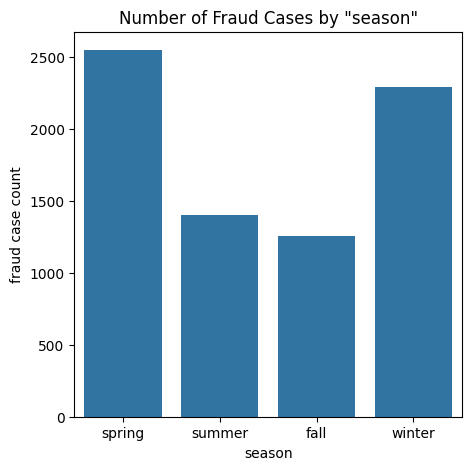

<ipython-input-28-7eccc495e557>:12: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set(xticklabels= p_axis[index])


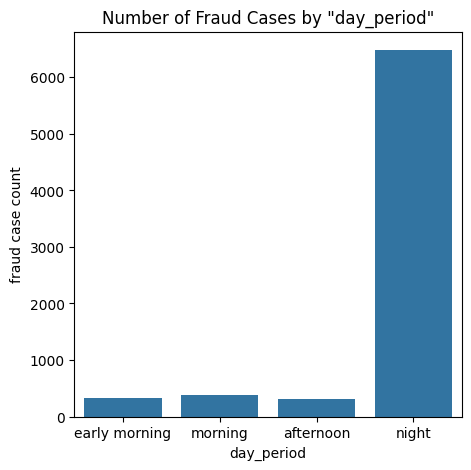

<ipython-input-28-7eccc495e557>:12: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set(xticklabels= p_axis[index])


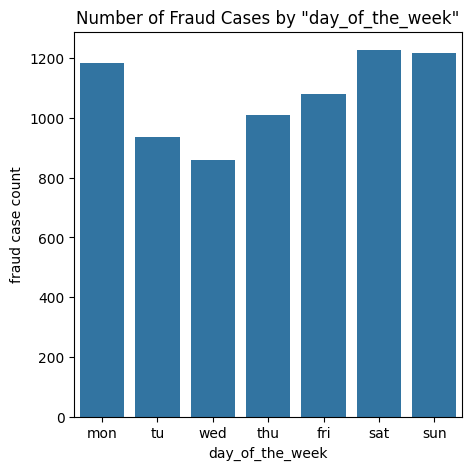

In [ ]:
# This code visualizes the distribution of fraud cases across different temporal features
# using count plots. Each plot highlights the count of fraud cases for the specified feature
# with customized titles and x-axis labels for better interpretability
fraud_time_df = time_df[time_df['is_fraud'] ==1]
time_x = ['season', 'day_period', 'day_of_the_week']
p_title = [f'Number of Fraud Cases by "{x}"' for x in time_x]
p_axis = [['spring','summer','fall','winter'], ['early morning','morning','afternoon','night'], ['mon','tu','wed','thu', 'fri', 'sat', 'sun']]

for index in range(3):
  plt.figure(figsize=(5,5))
  ax = sns.countplot(fraud_time_df, x= time_x[index], hue= 'is_fraud', legend=False)
  ax.set(xticklabels= p_axis[index])
  plt.title(p_title[index])
  plt.xlabel(time_x[index])
  plt.ylabel('fraud case count')
  plt.show()

Key Takeaways
1.	Fraud by Season:
	-	Spring has the highest number of fraud cases, followed by Winter.
	-	Summer and Fall have significantly fewer fraud cases compared to Spring and Winter.
	-	This suggests a possible seasonal pattern in fraudulent activities, with a peak during Spring.
2.	Fraud by Day Period:
	-	Fraud cases overwhelmingly occur at night, with minimal activity during early morning, morning, or afternoon periods.
	-	This indicates that fraudulent transactions are more likely to take place during hours when monitoring may be reduced or when individuals are less likely to notice suspicious activity.
3.	Fraud by Day of the Week:
	-	Fraudulent activities are relatively consistent across the week but show a slight peak on weekends Saturday and Sunday.
	- This suggests that fraudsters may exploit potential lapses in vigilance or monitoring systems during weekends.

In [ ]:
# Check the dataframe
time_df.head()

,trans_num,is_fraud,day_of_the_week,season,day_period
0,0b242abb623afc578575680df30655b9,0,1,3,3
1,1f76529f8574734946361c461b024d99,0,1,3,3
2,a1a22d70485983eac12b5b88dad1cf95,0,1,3,3
3,6b849c168bdad6f867558c3793159a81,0,1,3,3
4,a41d7549acf90789359a9aa5346dcb46,0,1,3,3


## **2.2** Encoding state


###**2.2.1** Data Pre-Processing
The dataset contains state-level information, which can be too granular and high-dimensional to use directly as features for modeling. To address this issue and simplify the feature space, we decided to group individual states into broader, geographically meaningful regions. By consolidating states into regions, we aim to capture geographic patterns more effectively while reducing dimensionality, improving the interpretability and performance of machine learning models.




The United States is divided into five commonly recognized regions:





1.   west_states
2.   southwest_states
3.   midwest_states
4.   southeast_states
5.   northeast_states



Each state is mapped to one of these regions based on its geographic location. This grouping helps capture regional trends that may influence transaction behaviors or fraud patterns. For instance, certain regions may have higher fraud rates or distinct transaction patterns due to economic, cultural, or geographic factors.

After assigning regions to states, we applied a OneHotEncoder to convert the categorical values of the region column into numerical features. This ensures that the machine learning models can leverage these regional patterns without misinterpreting any ordinal or hierarchical relationship between the regions.

In [ ]:
#put all states into 5 different regions
west_states = ["CA", "OR", "WA", "AK", "HI", "ID", "MT", "WY", "NV", "UT", "CO"]
southwest_states = ["AZ", "NM", "OK", "TX"]
midwest_states = ["ND", "SD", "NE", "KS", "MO", "IA", "MN", "WI", "IL", "IN", "OH", "MI"]
southeast_states = ["AR", "LA", "MS", "AL", "GA", "FL", "SC", "NC", "TN", "KY", "WV", "VA"]
northeast_states = ["ME", "NH", "VT", "MA", "RI", "CT", "NY", "NJ", "PA", "DE", "MD", "DC"]

#define a function which would categorize all states into different regions
def get_region(state):
    if state in west_states:
        return "West"
    elif state in southwest_states:
        return "Southwest"
    elif state in midwest_states:
        return "Midwest"
    elif state in southeast_states:
        return "Southeast"
    elif state in northeast_states:
        return "Northeast"
    else:
        return "Unknown"
#extract only the state column
state_df = credit_df[['trans_num','is_fraud', 'state']]

#apply the previously defined function to each row of the state column
state_df['region'] = state_df['state'].apply(get_region)

<ipython-input-30-5af70afe26f3>:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  state_df['region'] = state_df['state'].apply(get_region)


###**2.2.2** Data Encoding

In [ ]:
# use OneHot encode to the 'region' column
encoder = OneHotEncoder(sparse_output=False)

# Fit & transform on the relevant columns
region_encoded = encoder.fit_transform(state_df[['region']])

#Convert to DataFrame for readability
region_encoded_df = pd.DataFrame(region_encoded, columns=encoder.get_feature_names_out(['region']))

#Concatenate data
state_df = pd.concat([state_df, region_encoded_df], axis=1)

###**2.2.3** Visualization

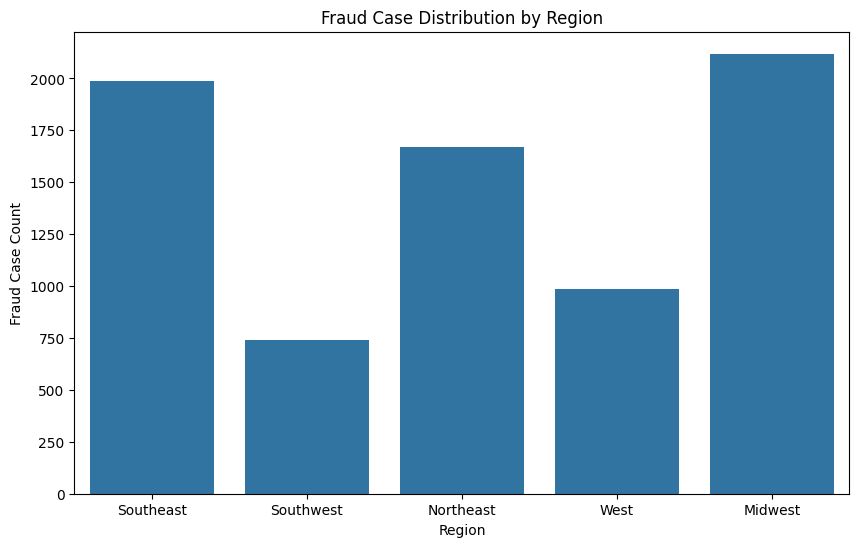

In [ ]:
# Filter dataset to include only fraud cases
fraud_cases = state_df[state_df['is_fraud'] == 1]

# Plot fraud case distribution by region
plt.figure(figsize=(10, 6))
ax = sns.countplot(data=fraud_cases, x='region')
plt.title('Fraud Case Distribution by Region')
plt.xlabel('Region')
plt.ylabel('Fraud Case Count')
plt.show()

In [ ]:
state_df.drop(columns= ['state', 'region'], inplace = True)

In [ ]:
state_df = state_df.astype({'region_Midwest': 'int', 'region_Northeast' :'int' , 'region_Southeast' : 'int', 'region_Southwest' : 'int', 'region_West' : 'int'})

In [ ]:
state_df.head()

,trans_num,is_fraud,region_Midwest,region_Northeast,region_Southeast,region_Southwest,region_West
0,0b242abb623afc578575680df30655b9,0,0,0,1,0,0
1,1f76529f8574734946361c461b024d99,0,0,0,0,0,1
2,a1a22d70485983eac12b5b88dad1cf95,0,0,0,0,0,1
3,6b849c168bdad6f867558c3793159a81,0,0,0,0,0,1
4,a41d7549acf90789359a9aa5346dcb46,0,0,0,1,0,0


Key Takeaways


1.   Fraud by Region:
  *   The Southeast region exhibits the highest number of fraud cases compared to all other regions.
  *   The Midwest region closely follows with a significant number of fraud cases, indicating high fraudulent activity in this area as well.
  *   Southwest has the lowest count of fraud cases, suggesting potentially lower fraud risks or fewer transactions in this region.
  *   The West region shows moderate fraud activity, while the Northeast region also has a considerable number of fraud cases.
2.   Regional Trends:
  *   The high fraud cases in the Southeast and Midwest regions could indicate region-specific factors such as transaction volume, population density, or economic activities that make them more susceptible to fraudulent activities.
  *   Lower fraud activity in the Southwest region may reflect stricter monitoring systems or lower transaction volume.
3.   Insights for Monitoring:
  *   Fraud detection efforts may need to focus more on the Southeast and Midwest regions due to their high fraud counts.
  *   Further investigation is needed to identify specific regional factors (e.g., economic or demographic influences) driving the patterns observed in these areas.

## **2.3** Encoding merchant category


There're too many merchant categories in the data, which makes it challenging to directly use them as features for analysis or modeling. To address this issue and simplify the features, we decided to group similar merchant categories into broader, more meaningful groups. By consolidating these categories, we aim to reduce the dimensionality of the feature space and make the data more manageable for processing.

After defining these broader groups, we apply an one hot encoding strategy to convert the categorical values into a numerical format suitable for machine learning models.

Encoding '**Category**' into OneHotEncoder based on information:

* 1. grocery: grocery_pos, grocery_net
* 2. shopping: shopping_net, shopping_pos
* 3. home: kids_pets, home
* 4. health: personel_care, health_fitness
* 5. leisure: entertainment, food_dining, travel
* 6. gas: gas_transport
* 7. misc: misc_net, misc_pos



### **2.3.1** Data Encoding

In [ ]:
# Only process 'category'
category_df = cat_df[['trans_num', 'is_fraud', 'category']]

In [ ]:
# Mapping each column to a category
category_mappings = {
    'grocery': ['grocery_pos', 'grocery_net'],
    'shopping': ['shopping_net', 'shopping_pos'],
    'home': ['kids_pets', 'home'],
    'health': ['personel_care', 'health_fitness'],
    'leisure': ['entertainment', 'food_dining', 'travel'],
    'gas': ['gas_transport'],
    'misc': ['misc_net', 'misc_pos']
}

# Reverse the mapping to make lookup easier
category_lookup = {item: category for category, items in category_mappings.items() for item in items}
print(category_lookup)
category_df['mercant_category'] = category_df['category'].map(category_lookup)
# Fill NA to misc group
category_df['mercant_category'] = category_df['mercant_category'].fillna("misc")


{'grocery_pos': 'grocery', 'grocery_net': 'grocery', 'shopping_net': 'shopping', 'shopping_pos': 'shopping', 'kids_pets': 'home', 'home': 'home', 'personel_care': 'health', 'health_fitness': 'health', 'entertainment': 'leisure', 'food_dining': 'leisure', 'travel': 'leisure', 'gas_transport': 'gas', 'misc_net': 'misc', 'misc_pos': 'misc'}


<ipython-input-37-94227749575b>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  category_df['mercant_category'] = category_df['category'].map(category_lookup)
<ipython-input-37-94227749575b>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  category_df['mercant_category'] = category_df['mercant_category'].fillna("misc")


In [ ]:
# Apply OneHotEncoder to the this categorical category column
onehotencoder = OneHotEncoder(sparse_output=False)
category_encoded = onehotencoder.fit_transform(category_df[['mercant_category']])
# Convert to DataFrame for readability
category_encoded_df = pd.DataFrame(category_encoded, columns=onehotencoder.get_feature_names_out(['mercant_category']))
# Concatenate data frame
category_df = pd.concat([category_df, category_encoded_df], axis = 1)
# Cast all encoded data to integer
var_toInt = onehotencoder.get_feature_names_out(['mercant_category'])
category_df[var_toInt] = category_df[var_toInt].astype(int)

### **2.3.2** Visualization

Barplot of number of fraudulent cases per class in each categorical variable.

In [ ]:
# helper function: Barplot of categorical variable

def barplot_cases(input_df = category_df, column = 'category'):

  column_counts = input_df[column].value_counts()
  # Only fraud cases
  input_df_onlyF = input_df[input_df['is_fraud']==1]
  input_onlyFraud_counts = input_df_onlyF[column].value_counts()

  plt.rcParams['font.family'] = 'DejaVu Sans'
  sns.set(rc = {'figure.figsize':(6,4)})
  sns.set_style('white')

  # # Bar 1: plot all cases
  column_counts.plot(kind='bar', figsize=(6, 4))
  plt.title(f'Frequency of cases by {column}')
  plt.xlabel(column.capitalize())
  plt.ylabel('Frequency')
  plt.xticks(rotation=90)
  plt.show()

  # # Bar 2: plot of these top categories
  # sns.countplot(data=input_df, x=column, hue='is_fraud', palette='viridis', dodge=True)
  # plt.title(f'Frequency of fraud cases by {column}')
  # plt.xlabel(column)
  # plt.ylabel('Frequency')
  # plt.xticks(rotation=90)
  # plt.show()

  # Bar 3: plot only Fraud cases
  input_onlyFraud_counts.plot(kind='bar', figsize=(6, 4))
  plt.title(f'Frequency of fraud cases (only) by {column}')
  plt.xlabel(column)
  plt.ylabel('Frequency')
  plt.show()


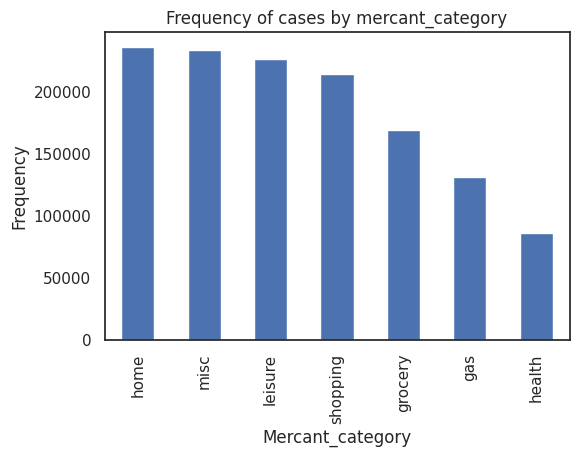

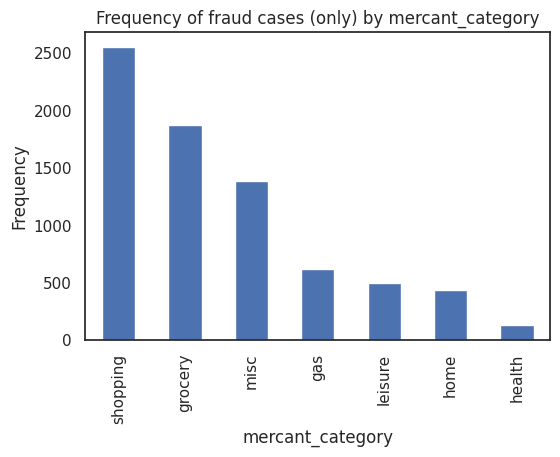

In [ ]:
# Barplot
barplot_cases(input_df = category_df, column = 'mercant_category')


Takeaway:

* Overall, the most common merchant categories in this dataset are home, misc, and leisure. These categories account for a significant proportion of the total transactions, suggesting that consumer spending is concentrated in these areas.
* However, the fraud is not uniformly distributed.
* Fraudulent transactions are highly concentrated in the **shopping** category, which accounts for the largest share of fraud cases by a significant margin. The grocery category shows the second-highest frequency of fraud cases, followed by misc.

* The high fraudulent frequcnies in shopping suggests that fraud detection strategies should prioritize this category or top 3 categories.





We next clean columns and prepare for downstream merge data.




In [ ]:
# Drop category columns and senity check unique values
category_df = category_df.drop(columns=['category','mercant_category'])

In [ ]:
category_df.head()

,trans_num,is_fraud,mercant_category_gas,mercant_category_grocery,mercant_category_health,mercant_category_home,mercant_category_leisure,mercant_category_misc,mercant_category_shopping
0,0b242abb623afc578575680df30655b9,0,0,0,0,0,0,1,0
1,1f76529f8574734946361c461b024d99,0,0,1,0,0,0,0,0
2,a1a22d70485983eac12b5b88dad1cf95,0,0,0,0,0,1,0,0
3,6b849c168bdad6f867558c3793159a81,0,1,0,0,0,0,0,0
4,a41d7549acf90789359a9aa5346dcb46,0,0,0,0,0,0,1,0


## **2.4** Encoding gender


We will encode gender 'M' as 0 and 'F' as 1 using OneHotEncoder.


### **2.4.1** Encoding

In [ ]:
# Extract only gender column
gender_df =  cat_df[['trans_num', 'is_fraud', 'gender']]

In [ ]:
# Apply OHE to the unordered_categorical cols
onehotencoder = OneHotEncoder(drop='first', sparse_output=False)

# Fit & transform on the relevant columns
gender_encoded = onehotencoder.fit_transform(gender_df[['gender']])

# Convert to DataFrame for readability
gender_encoded_df = pd.DataFrame(gender_encoded, columns=onehotencoder.get_feature_names_out(['gender']))

# Concatenate data
gender_df = pd.concat([gender_df, gender_encoded_df], axis = 1)
gender_df['gender_M'] = gender_df['gender_M'].astype(int)

### **2.4.2** Visualization

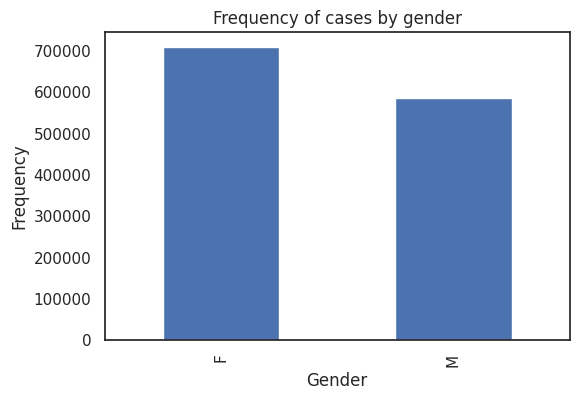

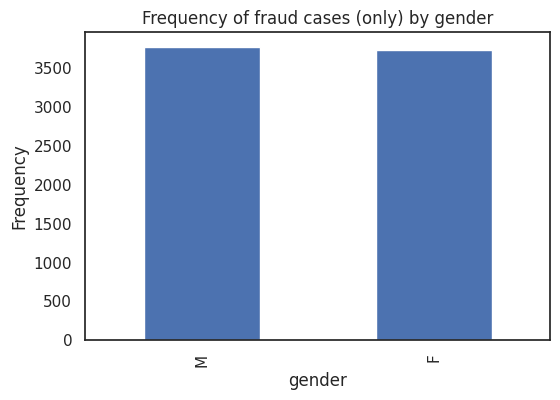

In [ ]:
# Bar plot of cases
barplot_cases(input_df = gender_df, column = 'gender')


Takeaway:

* In this data, there is a higher proportion of female samples compared to male samples, indicating that female individuals are overrepresented in the total number of transactions or cases.

* However, despite the larger number of female samples overall, the proportion of fraud cases between male and female samples appears to be relatively balanced.

* This suggests that fraud occurrence is not strongly influenced by gender in this dataset. Both male and female samples seem equally susceptible to fraudulent activity when compared proportionally to their respective populations.




We next clean columns and prepare for downstream merge data.


In [ ]:
# Drop gender column and only keey encoded column.
gender_df = gender_df.drop(columns='gender')
gender_df.head()

,trans_num,is_fraud,gender_M
0,0b242abb623afc578575680df30655b9,0,0
1,1f76529f8574734946361c461b024d99,0,0
2,a1a22d70485983eac12b5b88dad1cf95,0,1
3,6b849c168bdad6f867558c3793159a81,0,1
4,a41d7549acf90789359a9aa5346dcb46,0,1


## **2.5** Encoding job


To handle the high cardinality of the job column, the job titles will be grouped into broader categories:

  - ['engineering', 'education', 'medical', 'law', 'admin', 'art', 'finance', 'science', 'blue_collar', 'media', 'business', 'other'].

Each job will be mapped to one of these categories based on its characteristics, and then the resulting categorical feature will be encoded using a one-hot encoder. This approach reduces the dimensionality of the feature space while preserving the categorical nature of the data, ensuring that job information is represented effectively for use in the model.

In the section we will be using "Polars" due to merging large data size

### **2.5.1** Processing and Analyzing Job Titles for Fraud Detection Insights

In [ ]:
# converts a given text to lowercase and removes punctuation characters
def text_processor(text):
    text = text.lower()
    translator = str.maketrans('', '', punctuation)
    return text.translate(translator)

# processes a list of job titles, counts the occurrences of each word, and returns the word count sorted by frequency and alphabetically
def get_most_job(job: list) -> dict:
    job_words = [word for title in job for word in title.split(' ') ]
    count_dict = dict(Counter(job_words))
    return sorted(count_dict.items(), key=lambda kv: (kv[1], kv[0]))

# creates a DataFrame containing selected columns from cat_df and applies the text_processor function to clean the ‘job’ column
cleaned_job_df = cat_df[['job', 'trans_num', 'is_fraud']]
cleaned_job_df['job'] = cleaned_job_df['job'].apply(lambda x: text_processor(x))

<ipython-input-47-8965ae478d7e>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cleaned_job_df['job'] = cleaned_job_df['job'].apply(lambda x: text_processor(x))


### **2.5.2*** Classifying Job Titles into Industry Categories

In [ ]:
# create lists for each of the job categories
engineering = ['engineer', 'analyst', 'technician', 'developer','mudlogger','programmer']
education = ['teacher', 'education','mentor','learning', 'trainer', 'academic','professor', 'librarian']
medical = ['doctor','nurse','medic','psych','mental','hospital','therapist','pharma','surgeon','health','pathologist','hygienist', 'herbalist','immunologist', 'radiographer', 'podiatrist', ' diagnosis','optometrist','optician','nutritionist','orthoptist','ambulance', 'chiropodist','osteopath','acupuncturist','homeopath']
law = ['lawyer', 'attorney', 'police', 'ranger', 'firefighter', 'legal', 'barrister', 'conveyancer','conservator']
admin= ['officer', 'coordinator', 'consultant', 'planner', 'manager','staff','admin','secretary','organiser','forwarder','careers']
art =  ['art', 'music','editor', 'write', 'designer', 'architect','illustrator','director','photographer','animator', 'dancer','producer', 'gaffer']
finance = ['sell', 'buyer', 'sale', 'trader', 'trade','finance','financial','bank', 'market', 'buy','tax','clert','account','comptroller','economist']
science = ['scien', 'research', 'technologist', 'gist','statistician', 'merchandiser','chemist','geneticist','oceanographer', 'arboriculturist','horticulturist','lexicographer']
blue_collar = ['surveyor','landgeomatics', 'assistant','worker', 'inspect', 'service', 'operator', 'contractor','barista','curator','archivist', 'controller']
media = ['media','journal','broadcast','press', 'stream', 'tele','magazine','newspaper','interpreter']
business = ['airline', 'cabin', 'fundraiser', 'charity', 'insurance', 'dealer', 'brewer','broker','solicitor']
other = []

# create lists for later processing
job_cat = ['engineering', 'education' , 'medical', 'law', 'admin', 'art' , 'finance', 'science', 'blue_collar', 'media', 'business', 'other']
job_list = [engineering, education, medical, law, admin, art, finance, science, blue_collar, media, business, other]
job_df_list = ['']*12
job_df = cleaned_job_df[['job', 'trans_num']]

### **2.5.3** Classifying Job Titles into Industry Categories

In [ ]:
# create polars df
job_df = pl.from_pandas(cleaned_job_df)

In [ ]:
# go through all the job categories and create a list of dataframes according to job_cat
for index, job in enumerate(job_cat):
    if index == 0:
        job_df_list[index] = job_df.clone()
    else:
        job_df_list[index] = job_df_list[index - 1].filter(pl.col(job_cat[index - 1]) == 0)
        job_df_list[index - 1] = job_df_list[index - 1].drop(['job'])
    if job == 'other':
        job_df_list[index] = job_df_list[index].with_columns(
            pl.lit(1).alias(job)
        )
    else:
        job_df_list[index] = job_df_list[index].with_columns(
            pl.when(pl.col('job').str.contains('|'.join(job_list[index]))).then(1).otherwise(0).alias(job)
        )
    if index != 0:
        job_df_list[index] = job_df_list[index].drop([job_cat[index - 1]])

# drop the job column from the dataframe
job_df_list[-1] = job_df_list[-1].drop(['job'])

### **2.5.4** Merging and Finalizing Industry Classification Data for Job Titles

In [ ]:
# merge all the dataframe to a single dataframe
temp = None
for i , df in enumerate(job_df_list):
  if i == 0:
     temp = df.clone()
  else:
     temp = temp.join(df, on = 'trans_num', how = 'full')
     temp = temp.drop(['trans_num_right', 'is_fraud_right'])
     temp = temp.fill_null(0)
# turn it back to pandas dataframe
job_df = temp.to_pandas()

### **2.5.5** Visualization

In [ ]:
# create three different dictionaries
job_num_count = dict()
job_fraud_count = dict()
job_percent = dict()
for job in job_cat:
   job_num_count[job] = job_df[job].sum()
   job_fraud_count[job] = len(job_df[(job_df[job] == 1) & (job_df['is_fraud'] == 1)])
   job_percent[job]= (job_fraud_count[job] / job_num_count[job])*100

# create 3 dfs and put them into a list
col_list = ['total_job','num_fraud', 'percent_fraud']
dict_list = [job_num_count, job_fraud_count, job_percent]
df_list = [''] * 3

for i in range(3):
  df_list[i] = (pd.DataFrame ({'title' : job_cat, col_list[i] : dict_list[i].values()})).sort_values(col_list[i], ascending=False)

          title  total_job
2       medical     214994
4         admin     207415
0   engineering     180036
5           art     178412
7       science     154248
1     education      97579
8   blue_collar      95136
6       finance      76333
3           law      36861
10     business      25281
11        other      15406
9         media      14974


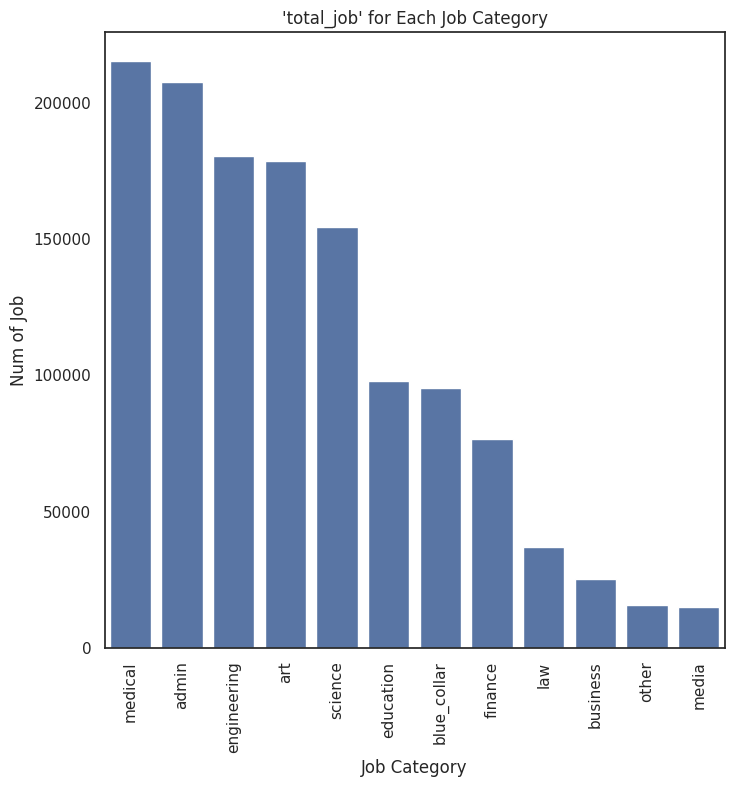

          title  num_fraud
4         admin       1338
2       medical       1212
5           art        969
0   engineering        961
7       science        834
1     education        607
8   blue_collar        572
6       finance        484
3           law        226
10     business        156
9         media         99
11        other         48


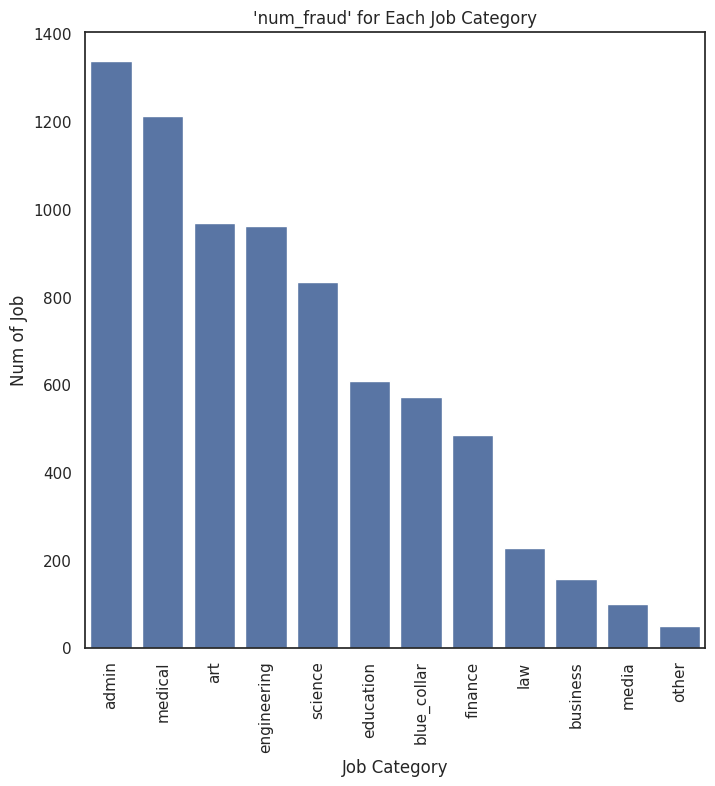

          title  percent_fraud
9         media       0.661146
4         admin       0.645084
6       finance       0.634064
1     education       0.622060
10     business       0.617064
3           law       0.613114
8   blue_collar       0.601245
2       medical       0.563737
5           art       0.543125
7       science       0.540688
0   engineering       0.533782
11        other       0.311567


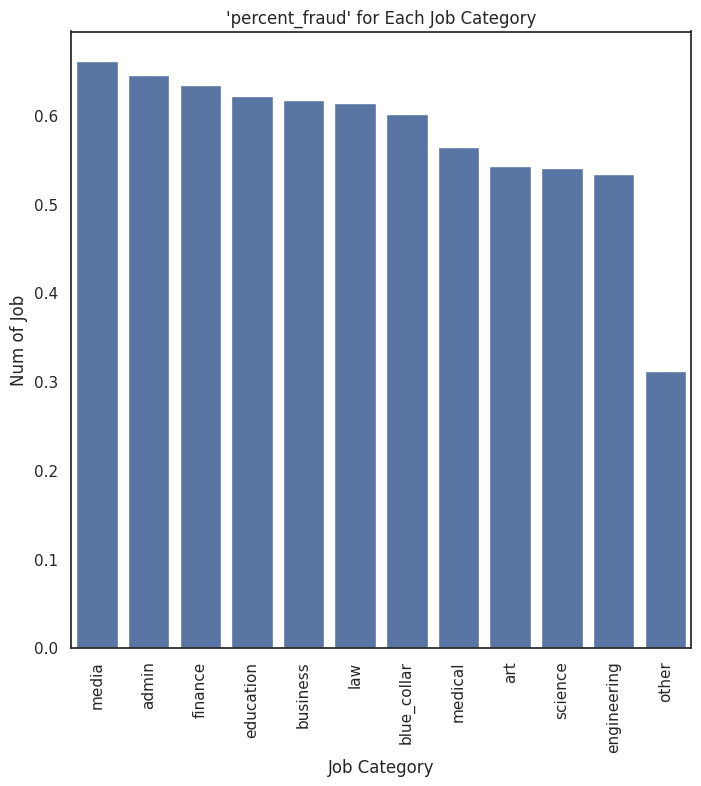

In [ ]:
for i in range(3):
  print(df_list[i])
  plt.figure(figsize=(8,8))
  ax = sns.barplot(df_list[i], x = 'title', y = col_list[i], legend=False)
  plt.title(f'\'{col_list[i]}\' for Each Job Category')
  plt.xlabel('Job Category')
  plt.xticks(rotation=90)
  plt.ylabel('Num of Job')
  plt.show()

**Total Jobs by Category:**
* Medical and Admin Lead: Medical and administrative categories have the highest number of total jobs.
  - Medical: 214,994 jobs (highest)
  - Admin: 207,415 jobs
* Engineering and Art Follow: Engineering and art have a significant number of jobs, both nearing 170,000.
* Lower Job Categories: Media, business, and "other" categories have the least number of jobs, each significantly below 50,000.

**Fraud Cases by Job Category:**
* Categories like media, admin, and finance exhibit high fraud percentages. This suggests a notable volume of fraud in these sectors.
  - Admin: 1,338 cases (highest)
  - Medical: 1,212 cases
  - Art: 969 cases

**Percentage of Fraud Cases per Category:**
* Highest Fraud Percentage: Media, admin, and finance have the highest fraud rates, with over 60% of their cases being fraudulent.
  - Media: 66.1% of jobs are fraudulent (highest)
  - Admin: 64.5%
  - Finance: 63.4%

* Other Categories Have Lower Fraud Rates
  - Other: 31.2% of jobs are fraudulent (lowest)
  - Engineering: 53.4%
  - Science: 54.1%

Key Takeaways:
* Medical, admin, and engineering sectors are critical to the economy but demonstrate significant vulnerabilities to fraud, making them strong candidates for future modeling and analysis.
* The media sector, while having the smallest total job count (14,974), exhibits the highest fraud rate at 66.1%, highlighting its disproportionate susceptibility to fraudulent activities.

## **2.6** Encode age



We will encode 'dob' column into age

### **2.6.1** Data Encoding

In [ ]:
# Extract age
age_df = num_df[['trans_num', 'is_fraud', 'dob']]

In [ ]:
# Convert 'dob' to datetime format
age_df['dob'] = pd.to_datetime(age_df['dob'])

# Get current date
current_date = pd.Timestamp.now()

# Calculate age as subtraction of current year and dob year
age_df['age'] = current_date.year - age_df['dob'].dt.year
#age_df['age'] = age_df['age'].astype('int')


<ipython-input-55-4166a6db86c4>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  age_df['dob'] = pd.to_datetime(age_df['dob'])
<ipython-input-55-4166a6db86c4>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  age_df['age'] = current_date.year - age_df['dob'].dt.year


### **2.6.2** Visualization

In [ ]:
# Helper function: Plot histograms for numerical variable
def hist_numeric_simp(input_df, var):

    # Adjust the font size
    plt.rcParams.update({'font.size': 16})

    # Histogram 1: overall distribution of all cases
    # plt.figure(figsize=(6,4))
    # sns.histplot(input_df[var], bins=30, kde=True)
    # plt.title(f'Histogram of {var}')
    # plt.xlabel(var)
    # plt.ylabel('Frequency')
    # plt.show()

    # Histogram 2: split distribution by 'is_fraud'
    # Plot histogram with hue as 'is_fraud' to overlay fraud and non-fraud distributions
    plt.figure(figsize=(6,4))
    sns.histplot(data=input_df, x=var, hue='is_fraud', bins=30, kde=True, palette='viridis', element='step', stat="density", common_norm=False)
    plt.title(f'Histogram of {var}')
    plt.xlabel(var)
    plt.ylabel('Frequency')
    plt.show()



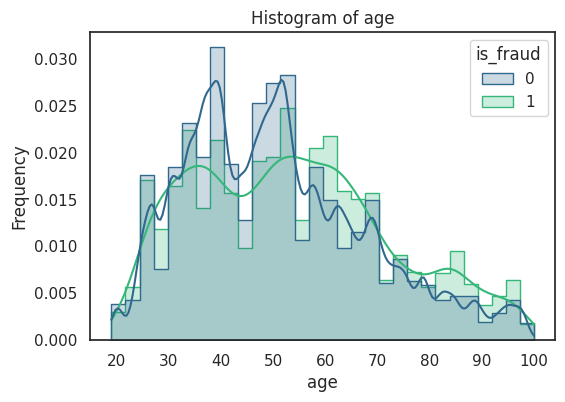

In [ ]:
# Visualize age distribution
hist_numeric_simp(input_df = age_df, var='age')


Takeaway:

* The age distribution between fraud cases and non-fraud cases are similar, no significant shifts were observed. Even though there's slightly higher fraud cases relative frequency in age 55-70 group than non-fraud cases.
* There're no obvious outliers in the feature.

In [ ]:
# Drop 'dob' column
age_df = age_df.drop(columns=['dob'])
age_df.head()

,trans_num,is_fraud,age
0,0b242abb623afc578575680df30655b9,0,36
1,1f76529f8574734946361c461b024d99,0,46
2,a1a22d70485983eac12b5b88dad1cf95,0,62
3,6b849c168bdad6f867558c3793159a81,0,57
4,a41d7549acf90789359a9aa5346dcb46,0,38


## **2.7** Encode distance



### **2.7.1**Data Pre-Processing

In the context of fraud detection, the geographic distance between the transaction location and the merchant location can be a strong indicator of fraudulent activity.

However, the dataset contains raw latitude and longitude information for both transaction and merchant locations, which are not directly usable as features. To address this, we calculated the geographic distance between the two locations for each transaction. This transformation condenses the geospatial information into a single numeric feature (**distance_km**), which can be more easily interpreted by machine learning models.

By transforming raw latitude and longitude values into a single distance_km feature, this encoding approach simplifies the feature space and enhances the dataset’s usability for machine learning. The resulting feature captures meaningful spatial relationships between transactions and merchant locations, aiding in the identification of anomalous patterns that might indicate fraud.

In [ ]:
#Extract the columns which will be used to calculate distance
distance_df = credit_df[['trans_num', 'is_fraud', 'lat', 'long', 'merch_lat', 'merch_long']]


# extract the numpy array of coordinates
transaction_coords = distance_df[['lat', 'long']].to_numpy()
merchant_coords = distance_df[['merch_lat', 'merch_long']].to_numpy()

# define the function used to calculate distance
def calculate_haversine_vectorized(trans_coords, merch_coords):
    """
    use haversine to calculate the distance between 2 np arries of coordinates in km
    """
    distances = np.array([
        haversine(trans, merch, unit=Unit.KILOMETERS)
        for trans, merch in zip(trans_coords, merch_coords)
    ])
    return distances


# calculate distance using calculate_haversine_vectorized function
distance_df['distance_km'] = calculate_haversine_vectorized(transaction_coords, merchant_coords)

<ipython-input-59-56b9e4765b10>:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  distance_df['distance_km'] = calculate_haversine_vectorized(transaction_coords, merchant_coords)


In [ ]:
distance_df.head(5)

,trans_num,is_fraud,lat,long,merch_lat,merch_long,distance_km
0,0b242abb623afc578575680df30655b9,0,36.0788,-81.1781,36.011293,-82.048315,78.597677
1,1f76529f8574734946361c461b024d99,0,48.8878,-118.2105,49.159047,-118.186462,30.212217
2,a1a22d70485983eac12b5b88dad1cf95,0,42.1808,-112.2620,43.150704,-112.154481,108.206232
3,6b849c168bdad6f867558c3793159a81,0,46.2306,-112.1138,47.034331,-112.561071,95.673363
4,a41d7549acf90789359a9aa5346dcb46,0,38.4207,-79.4629,38.674999,-78.632459,77.556851


### **2.7.2** Visualization

In [ ]:
# Filter dataset to include only fraud case
fraud_only_df = distance_df[distance_df['is_fraud'] == 1]

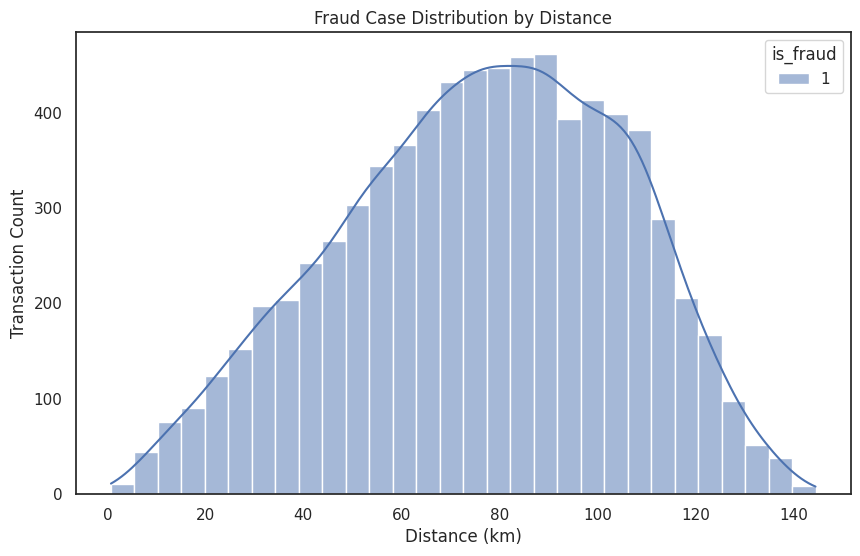

In [ ]:
# Visualize fraud cases distribution directly using distance_km with bins
plt.figure(figsize=(10, 6))
sns.histplot(data=fraud_only_df, x='distance_km', hue='is_fraud', bins=30, kde=True)
plt.title('Fraud Case Distribution by Distance')
plt.xlabel('Distance (km)')
plt.ylabel('Transaction Count')
plt.show()


Key Takeaways


1.   Fraud Cases by Distance:
  *   The distribution of fraud cases peaks at a **moderate distance (approximately 60-80 km)** between the transaction and merchant locations.
  *   Fraud cases are relatively fewer at **very short distances (less than 20 km)**, indicating that transactions occurring close to merchant locations might have a lower likelihood of being fraudulent.
  *   As the distance increases beyond **100 km**, the frequency of fraud cases gradually declines, suggesting that extremely long-distance transactions may be less common.
2.   Insights on Fraudulent Patterns:
  *   The concentration of fraud cases at moderate distances could be attributed to fraudsters trying to simulate realistic transaction patterns while avoiding very short or excessively long distances that might trigger suspicion.
  *   Short-distance transactions are less likely to be flagged as fraudulent, possibly because genuine cardholders typically perform transactions closer to their usual locations.
3.   Implications for Fraud Detection:
  *   Transactions with moderate distances between the transaction and merchant locations should be closely monitored, as they represent the highest risk for fraudulent activity.
  *   Extremely long-distance transactions, while less frequent, may still warrant attention in specific scenarios, such as international transactions or online fraud.

## **2.8** Encode population



We will visualize this variable by checking the histogram and boxplot of fraud cases and non-fraud cases, to identify the distribution of this feature and determine any potential outliers.

### **2.8.1** Visualization


In [ ]:
# Helper function: Plot histograms for numerical variable
def hist_numeric(input, var):

    # Apply log transformation, handling non-positive values by filtering them out
    input_df = input.copy()
    input_df['log_data'] = np.log10(input_df[var][input_df[var] > 0])

    # Adjust the font size
    plt.rcParams.update({'font.size': 22})

    # Boxplot 1: between fraud and non-fraud
    plt.figure(figsize=(5,4))
    sns.boxplot(data=input_df, x='is_fraud', hue='is_fraud', y=var, palette='viridis', legend=False, width=0.7)
    plt.title(f'Histogram of {var}')
    plt.xlabel('is_fraud')
    plt.ylabel(var)
    plt.show()

    # Boxplot 2: between fraud and non-fraud, using log scale
    plt.figure(figsize=(5,4))
    sns.boxplot(data=input_df, x='is_fraud', hue='is_fraud', y='log_data', palette='viridis', legend=False, width=0.7)
    plt.title(f'Histogram of {var} (log10)')
    plt.xlabel('is_fraud')
    plt.ylabel(var)
    plt.show()

    # Histogram 3: split distribution by 'is_fraud'
    # Plot histogram with hue as 'is_fraud' to overlay fraud and non-fraud distributions
    plt.figure(figsize=(6,4))
    sns.histplot(data=input_df, x=var, hue='is_fraud', bins=30, kde=True, palette='viridis', element='step', stat="density", common_norm=False)
    plt.title(f'Histogram of {var}')
    plt.xlabel(var)
    plt.ylabel('Frequency')
    plt.show()

    # Histogram 4: split distribution by 'is_fraud', distribution based on log scale
    plt.figure(figsize=(6,4))
    sns.histplot(data=input_df, x='log_data', hue='is_fraud', bins=30, kde=True, palette='viridis', element='step', stat="density", common_norm=False)
    plt.title(f'Histogram of {var} (log10)')
    plt.xlabel(var)
    plt.ylabel('Frequency')
    plt.show()



In [ ]:
# Extract city population
city_pop_df = num_df[['trans_num', 'is_fraud', 'city_pop']]

In [ ]:
city_pop_df.columns

Index(['trans_num', 'is_fraud', 'city_pop'], dtype='object')

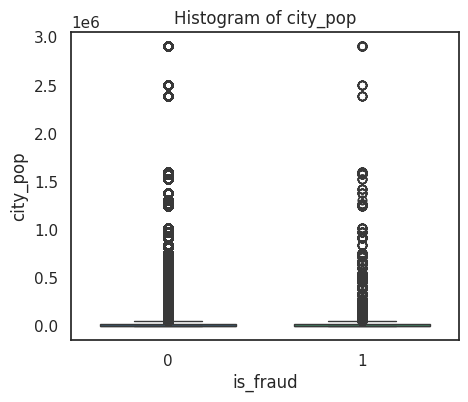

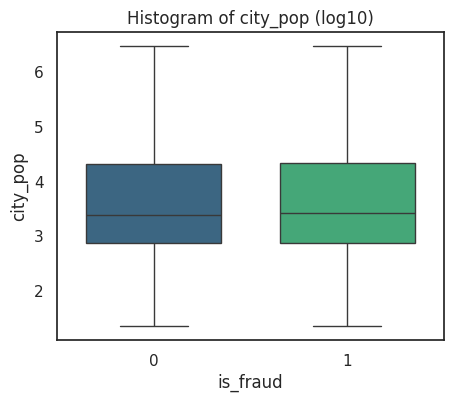

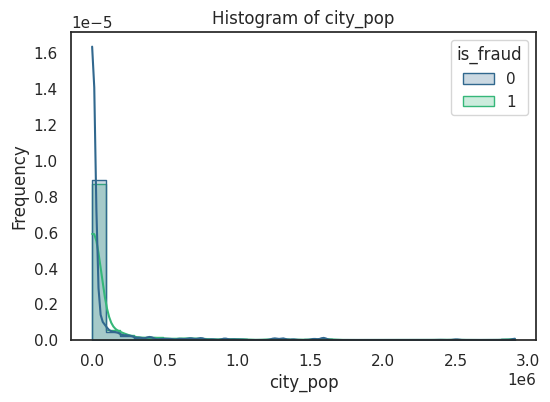

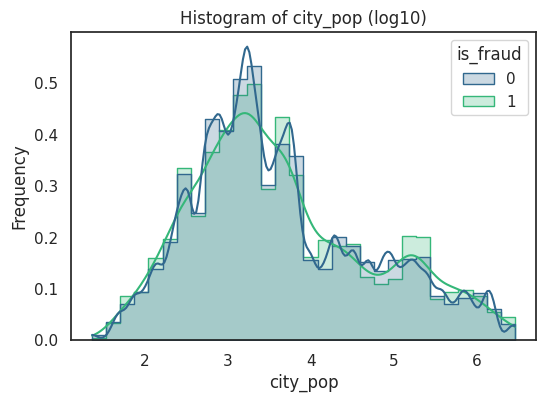

In [ ]:
# Histogram plot
hist_numeric(input = city_pop_df, var='city_pop')


Takeaway:

* The city population 'city_pop' feature is highly skewed towards to right. Therefore, we inspected the log-scale distribution.
* The distributions of city_pop between fraud cases and non-fraud cases are similar, no significant differences are observed.
* No obvious outlier were observed, rather the city population is in large range.
* In the downstream, to keep all numerical features in similar range, we will use StandardScaler() to normalized this feature.

In [ ]:
city_pop_df.head()

,trans_num,is_fraud,city_pop
0,0b242abb623afc578575680df30655b9,0,3495
1,1f76529f8574734946361c461b024d99,0,149
2,a1a22d70485983eac12b5b88dad1cf95,0,4154
3,6b849c168bdad6f867558c3793159a81,0,1939
4,a41d7549acf90789359a9aa5346dcb46,0,99


### **2.8.2** Outier and filter

Noticed there is no dramatic outlier of this variable, temporarily not perform filter.


## **2.9** Encode amount



###**2.9.1** Visualization
We noticed the variable 'amt' is skewed, so we plot histogram and log-scale of the variable

In [ ]:
# Extract transition amount data
amt_df = num_df[['is_fraud', 'trans_num', 'amt']]

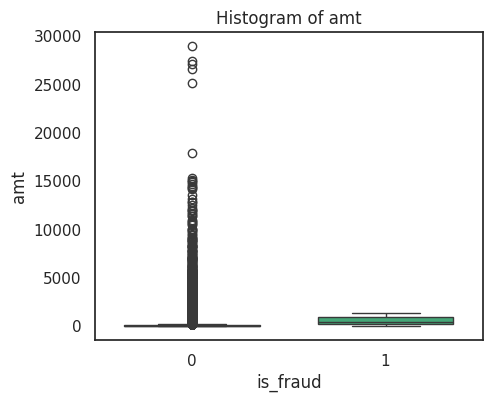

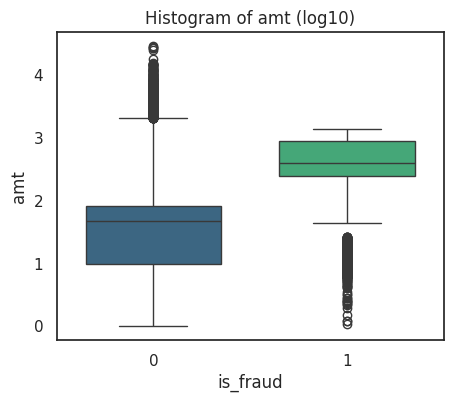

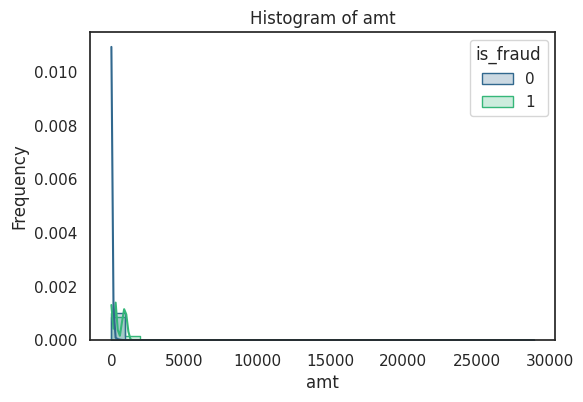

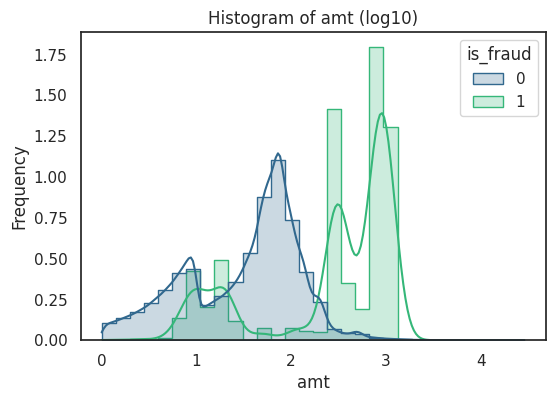

In [ ]:
# Visualize amont distribution in Histogram plot
hist_numeric(input = amt_df, var='amt')


Takeaway:


*  The original transaction amount values are highly skewed to the right (histogram), with most transaction amounts being small and a few extreme outliers with very large values (boxplot).
*  The is_fraud classes (0 = non-fraud, 1 = fraud) overlap for smaller values of amt besides outliers. But due to the large value range, it is difficult to observe patterns in smaller amounts.
*  Therefore, by taking Log-scale, we can see the fraudulent transactions (green) appear more prominently for larger amounts. To make all numerical variable in same range to avoid over weight any feature, StandardScaler() is applied for downstream modelling.




### **2.9.2** Outier and filter

Based on amount data distribution, We will perform filter and only keep amt in [5, 3000] data.


In [ ]:
# Create binary outlier variable, will use it to check outliers and create count table
amt_df_tmp = amt_df[['is_fraud','amt']]
amt_df_tmp['amt_isoutlier_v1'] = amt_df_tmp['amt'].astype('float64').apply(lambda x: 0 if (x>=5) & (x<3000) else 1 )

# Check number of fraud cases in the outliers
table = pd.crosstab(amt_df_tmp['amt_isoutlier_v1'], amt_df_tmp['is_fraud'],
                    rownames=['Outliers'], colnames=['Fraud status'])
print(table)


Fraud status        0     1
Outliers                   
0             1126654  7481
1              162515    25


Remove outliers.

In [ ]:
# Remove outliers
amt_df_filter = amt_df[amt_df_tmp['amt_isoutlier_v1']==0]
amt_df_filter.shape


(1134135, 3)

In [ ]:
amt_df_filter.head()

,is_fraud,trans_num,amt
1,0,1f76529f8574734946361c461b024d99,107.23
2,0,a1a22d70485983eac12b5b88dad1cf95,220.11
3,0,6b849c168bdad6f867558c3793159a81,45.00
4,0,a41d7549acf90789359a9aa5346dcb46,41.96
5,0,189a841a0a8ba03058526bcfe566aab5,94.63


### **2.9.3** Visualization after remove outliers


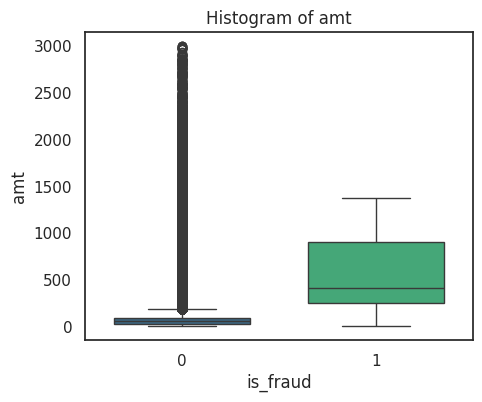

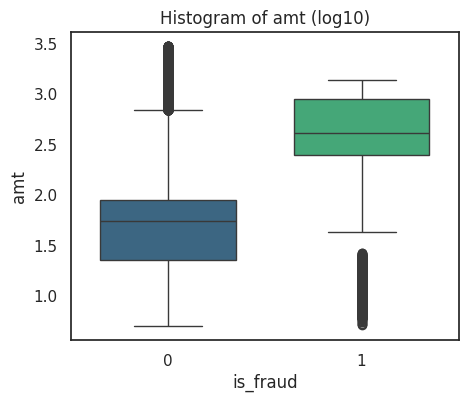

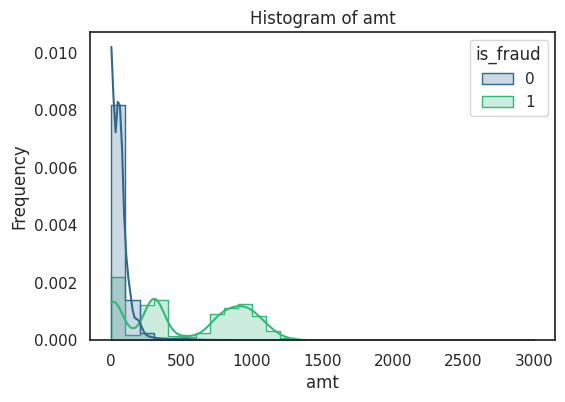

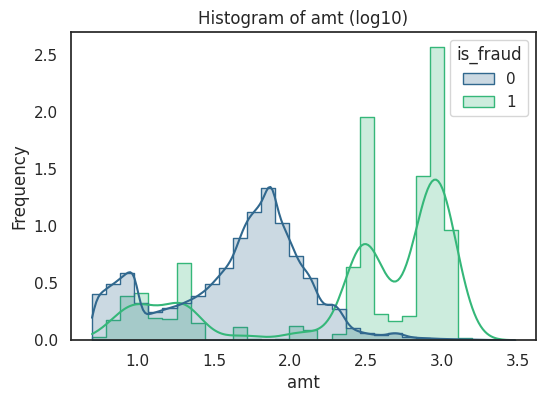

In [ ]:
# Visualize amont distribution in Histogram plot
hist_numeric(input = amt_df_filter, var='amt')


Takeaway:

* The transaction amount is highly skewed to the right, with most transaction amounts being relative small and a small proportion of large values.
* The amount distribution between fraud and non-fraud are different.
* Fraud case transactions are bi-model distribution (based on log-scale of histogram).
* Since the distributions differ, the amt is likely to be a significant feature for distinguishing fraudulent from non-fraudulent transactions.
* To make all numerical features compariable, we will apply StandardScaler() to normalize this feature.



# Part 3:  Merge Data and EDA


## **3.1** Merge Data
Using duckdb to create final used encoded data.

In [ ]:
# 创建 DuckDB 的内存数据库连接
con = duckdb.connect()

# 注册各表到 DuckDB
con.register('time_table', time_df)
con.register('state_table', state_df)
con.register('category_table', category_df)
con.register('gender_table', gender_df)
con.register('job_table', job_df)
con.register('age_table', age_df)
con.register('distance_table', distance_df)
con.register('city_pop_table', city_pop_df)
con.register('amt_table', amt_df_filter)


# 合并各表
query = """
SELECT
    time_table.*,
    state_table.region_Midwest,
    state_table.region_Southeast,
    state_table.region_Southwest,
    state_table.region_West,
    state_table.region_Northeast,
    category_table.mercant_category_gas,
    category_table.mercant_category_grocery,
    category_table.mercant_category_health,
    category_table.mercant_category_home,
    category_table.mercant_category_leisure,
    category_table.mercant_category_misc,
    category_table.mercant_category_shopping,
    gender_table.gender_M,
    job_table.engineering,
    job_table.education,
    job_table.medical,
    job_table.law,
    job_table.admin,
    job_table.art,
    job_table.finance,
    job_table.science,
    job_table.blue_collar,
    job_table.media,
    job_table.business,
    job_table.other,
    age_table.age,
    distance_table.distance_km,
    city_pop_table.city_pop,
    amt_table.amt
FROM time_table
JOIN state_table ON time_table.trans_num = state_table.trans_num
JOIN category_table ON time_table.trans_num = category_table.trans_num
JOIN gender_table ON time_table.trans_num = gender_table.trans_num
JOIN job_table ON time_table.trans_num = job_table.trans_num
JOIN age_table ON time_table.trans_num = age_table.trans_num
JOIN distance_table ON time_table.trans_num = distance_table.trans_num
JOIN city_pop_table ON time_table.trans_num = city_pop_table.trans_num
JOIN amt_table ON time_table.trans_num = amt_table.trans_num
"""

# 执行查询并将结果存储为 DataFrame
merged_df = con.execute(query).fetchdf()

# 关闭连接
con.close()


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

In [ ]:
merged_df.head()

,trans_num,is_fraud,day_of_the_week,season,day_period,region_Midwest,region_Southeast,region_Southwest,region_West,region_Northeast,...,finance,science,blue_collar,media,business,other,age,distance_km,city_pop,amt
0,082f3312856ca1b206b7029bc96d2b2a,0,4,0,3,1,0,0,0,0,...,0,0,0,0,0,0,44,88.633120,134056,69.18
1,8ac9700227707608eebf2c1c0e4280a7,0,4,0,3,1,0,0,0,0,...,0,0,0,0,0,0,46,79.618456,5760,56.46
2,c45a23f70bb0b4a198e9d218a30cc715,0,4,0,3,0,1,0,0,0,...,0,0,0,0,0,0,31,103.255373,5161,157.06
3,b3ca9149ec0c87c25989a634a07817f8,0,4,0,3,0,0,0,0,1,...,0,0,1,0,0,0,51,53.233580,3688,27.70
4,a945f32fe4964e0a35dbe2d7bfdbc088,0,4,0,3,0,1,0,0,0,...,1,0,0,0,0,0,53,84.057877,14228,33.28


In [ ]:
merged_df.shape

(1134135, 34)

##**3.2** Save data


In [ ]:
# Mount google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Write data to csv
merged_df.to_csv('/content/drive/My Drive/Final Project/merged_df.csv', index= False)

## **3.3** EDA - Correlation of all features



**Correlation Heatmap**: Correlation of all feature variables

In our data, most features are categorical variables, with limited numerical features. So we apply spearman correlation to examine pairwise correlations between each feature.  


In [ ]:
# Compute Spearman correlation
spearman_corr =  merged_df.drop(['trans_num'], axis=1).corr(method='spearman')

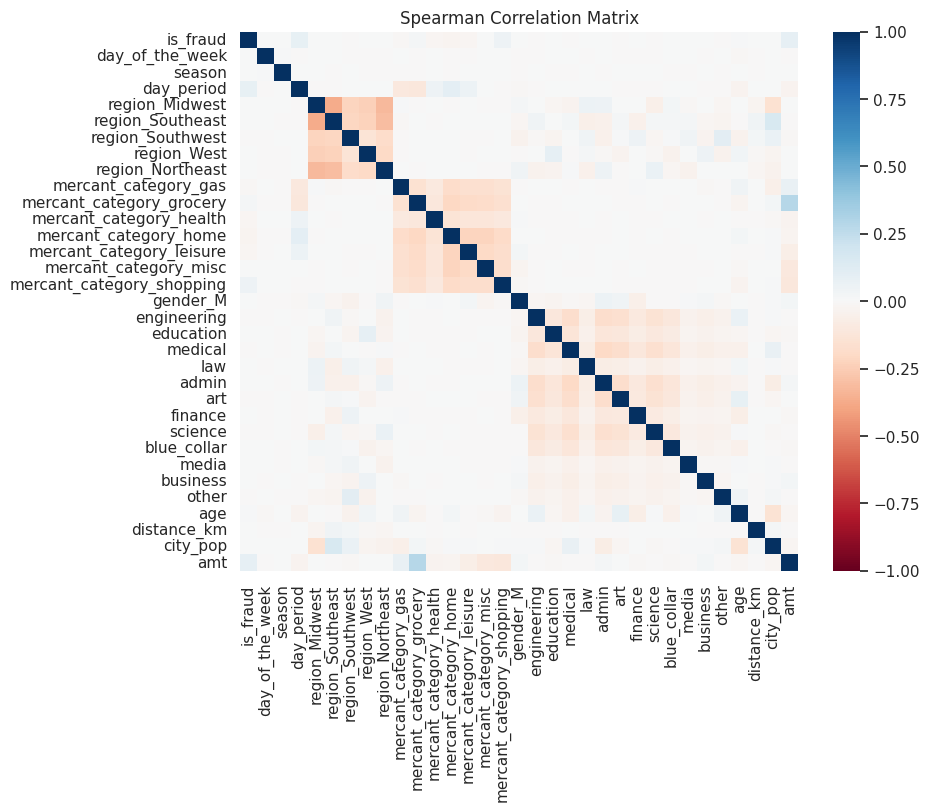

In [ ]:
# Feature correlation heatmap with numerical correlation values
plt.figure(figsize=(9,7))
sns.heatmap(spearman_corr, cmap='RdBu', vmin=-1, vmax=1, annot=False, fmt=".1f")
# Add title and axis labels
plt.title('Spearman Correlation Matrix')
plt.show()

Takeaway:

* Based on the heatmap, there're three chunk of relative highly negative correlated features, which are categorical variables from the same group, such as 5 regions (Midwest, Southeast, Southwest, West, Northeast) and the 7 merchant_categories.
* Other than that, no highly correlated variables are found.
* Similar to what we observed in previous section, several features showed slightly higher correlation with is_fraud, such as day_period and amt, might indicate behavioral patterns linked to fraud.


# Part 4: ML Modeling

## **4.0** Read Data

In [ ]:
# Mount google drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Read data from csv
merged_df = pd.read_csv('/content/drive/My Drive/Final Project/merged_df.csv')

In [ ]:
merged_df.head()

,trans_num,is_fraud,day_of_the_week,season,day_period,region_Midwest,region_Southeast,region_Southwest,region_West,region_Northeast,...,finance,science,blue_collar,media,business,other,age,distance_km,city_pop,amt
0,1f76529f8574734946361c461b024d99,0,1,3,3,0,0,0,1,0,...,0,0,0,0,0,0,46,30.212217,149,107.23
1,a1a22d70485983eac12b5b88dad1cf95,0,1,3,3,0,0,0,1,0,...,0,0,0,0,0,0,62,108.206232,4154,220.11
2,6b849c168bdad6f867558c3793159a81,0,1,3,3,0,0,0,1,0,...,0,0,0,0,0,0,57,95.673363,1939,45.00
3,a41d7549acf90789359a9aa5346dcb46,0,1,3,3,0,1,0,0,0,...,0,0,0,0,0,0,38,77.556851,99,41.96
4,189a841a0a8ba03058526bcfe566aab5,0,1,3,3,0,0,0,0,1,...,0,0,0,0,0,0,63,85.922761,2158,94.63


In [ ]:
merged_df.shape

(1134135, 34)

## **4.1** Train-Test Split

### **4.1.1** Training-Testing split

Prepare data for downstream modelling. We apply 80-20% train-test data split.


In [ ]:
# Extract the features and target variable
X = merged_df.drop(['trans_num', 'is_fraud'], axis=1)
y = merged_df['is_fraud']


In [ ]:
# Split the data into training and testing sets
SEED = 42
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=SEED)


### **4.1.2** Standard scale numerical features




**1.Why Do We Need to Scale Numerical Features?**




Numerical features in our dataset have vastly different ranges and scales. Machine learning algorithms, particularly those based on gradient descent (e.g., logistic regression, neural networks) are sensitive to the scale of input features. Without scaling, algorithms may become biased towards features with larger scales, as their larger values dominate distance calculations or contribute disproportionately to the loss function, and features with smaller ranges may be underrepresented or ignored during training

The ranges for our numerical features are as follows:
  *   Age: From 19 to 100 years
  *   Distance_km: From 0.022 km to 150.83 km
  *   City_pop: From 23 to 2,906,700 people
  *   Transaction Amount: From \$5 dollars to \$2,999.36

**2.Features to Scale:**


In this case, the following numerical features are identified for scaling:

  *   age: Represents the age of the cardholder and has a limited range (e.g., 18 to 100 years)
  *   distance_km: The distance between the transaction location and the merchant location, typically ranging from 0 to hundreds of kilometers
  *  city_pop: Represents the population of the city where the transaction occurred, potentially ranging from small towns to densely populated urban areas
  *   amt: Transaction amount, which can vary significantly depending on the type of transaction (e.g., small purchases vs. large business expenses)

**3.Scaling Approach:**

To standardize the numerical features, we use StandardScaler from the sklearn.preprocessing module, which applies the following transformation to each feature:
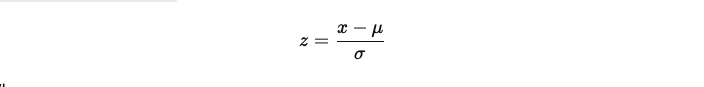
Where:



*   x is the original feature value
*   μ is the mean of the feature
*   σ is the standard deviation of the feature
*   z is the transformed feature value

This transformation ensures that each feature has:
*   A mean of 0
*   A standard deviation of 1


In [ ]:
numerical_features = ['age', 'distance_km', 'city_pop', 'amt']

X_train[numerical_features].describe()

,age,distance_km,city_pop,amt
count,907308.000000,907308.000000,9.073080e+05,907308.000000
mean,50.655307,76.112894,8.833470e+04,78.236562
std,17.281395,29.112981,3.017003e+05,119.130069
min,19.000000,0.093922,2.300000e+01,5.000000
25%,37.000000,55.355515,7.410000e+02,22.680000
50%,49.000000,78.220554,2.408000e+03,55.820000
75%,62.000000,98.495651,1.968500e+04,89.970000
max,100.000000,150.834590,2.906700e+06,2999.360000


In [ ]:
# Scale the numerical features by initializing the scaler and calling
numerical_features = ['age', 'distance_km', 'city_pop', 'amt']
scaler = StandardScaler()
X_train[numerical_features] = scaler.fit_transform(X_train[numerical_features])
X_test[numerical_features] = scaler.transform(X_test[numerical_features])


In [ ]:
# Convert X_train, y_train, X_test, y_test into numpy arrays
X_train_values = X_train.values
y_train_value = y_train.values
X_test_value = X_test.values
y_test_value = y_test.values

## **4.1** Base model

Dummy model -- To fit this imbalanced data in baseline model, we applied DummyClassifer with "stratified" strategy.

This classifier randomly predicts classes based on their proportions in the dataset.

### **4.1.1** Fit dummy model


In [ ]:
from sklearn.dummy import DummyClassifier

# Fit dummy Classifier using all features
dummy = DummyClassifier(strategy="stratified")
# Train the model
dummy.fit(X_train_values, y_train_value)


DummyClassifier(strategy='stratified')

### **4.1.2** Predict and evaluate model performance


In [ ]:
# Evaluate the Model
dummy_y_train_pred = dummy.predict(X_train_values)
dummy_y_test_pred = dummy.predict(X_test_value)


In [ ]:
# Helper function for model assessment
def get_classification_metrics(y_true, y_pred, model, data):
    """
    Generate a classification report, extract precision, recall, and F1 score
    for classes 0 and 1, and return them as a DataFrame.

    Parameters:
    y_true (array-like): True labels
    y_pred (array-like): Predicted labels

    Returns:
    DataFrame: Precision, recall, and F1 score for classes 0 and 1
    """
    # Generate classification report as a dictionary
    report_dict = classification_report(y_true, y_pred, output_dict=True)

    # Convert to a DataFrame
    classification_df = pd.DataFrame(report_dict).transpose()

    # Keep only precision, recall, and F1 score for classes 0 and 1
    classification_df = classification_df.loc[['0', '1'], ['precision', 'recall', 'f1-score']]
    classification_df['model'] = model
    classification_df['data'] = data

    return classification_df


In [ ]:
# Helper function for displaying confusion matrix
def display_confusion_matrix(y_true, y_pred, model, data):
    """
    Display a confusion matrix
    Parameters:
    y_true (array-like): True labels
    y_pred (array-like): Predicted labels
    """
    cm = confusion_matrix(y_true, y_pred)
    flipped_cm = np.array([[cm[1, 1], cm[0, 1]],
                           [cm[1, 0], cm[0, 0]]])
    # labels = np.array([["True Positive (TP)", "False Positive (FP)"],
    #                    ["False Negative (FN)", "True Negative (TN)"]])
    labels = np.array([["TP", "FP"],
                       ["FN", "TN"]])

    fig, ax = plt.subplots(figsize=(6, 4.5))

    # Create a table-like matrix with cell colors
    ax.imshow(flipped_cm, cmap="Blues", interpolation="nearest", aspect="auto")

    # Add text annotations to the cells
    for (i, j), val in np.ndenumerate(flipped_cm):
        text = f"{labels[i, j]}\n{val}"
        ax.text(j, i, text, ha="center", va="center", color="black", fontsize=13)

    # Set axis labels and ticks
    ax.set_xticks([0, 1])
    ax.set_yticks([0, 1])
    ax.set_xticklabels(["Actually Fraud", "Actually Not Fraud"], fontsize=14)
    ax.set_yticklabels(["Predict Fraud", "Predict Not Fraud"], fontsize=14)
    ax.set_xlabel("Actual Class", fontsize=14, weight="bold")
    ax.set_ylabel("Predicted Class", fontsize=14, weight="bold")

    # Set title
    plt.title("Confusion Matrix - " + model + " model, " + data, fontsize=14)

    plt.tight_layout()
    plt.show()


Training data:                precision    recall  f1-score   support

           0       0.99      0.99      0.99    901344
           1       0.01      0.01      0.01      5964

    accuracy                           0.99    907308
   macro avg       0.50      0.50      0.50    907308
weighted avg       0.99      0.99      0.99    907308

Testing data:                precision    recall  f1-score   support

           0       0.99      0.99      0.99    225310
           1       0.01      0.01      0.01      1517

    accuracy                           0.99    226827
   macro avg       0.50      0.50      0.50    226827
weighted avg       0.99      0.99      0.99    226827



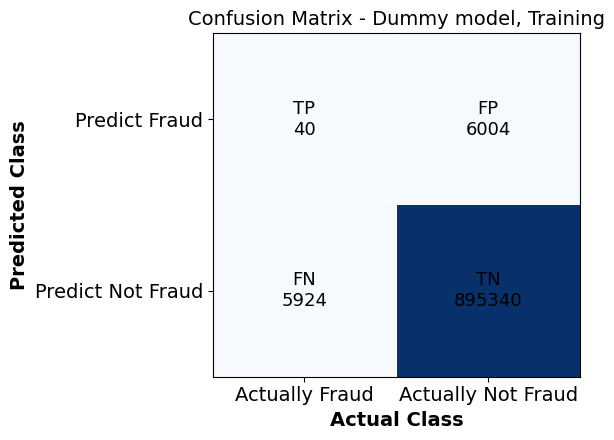

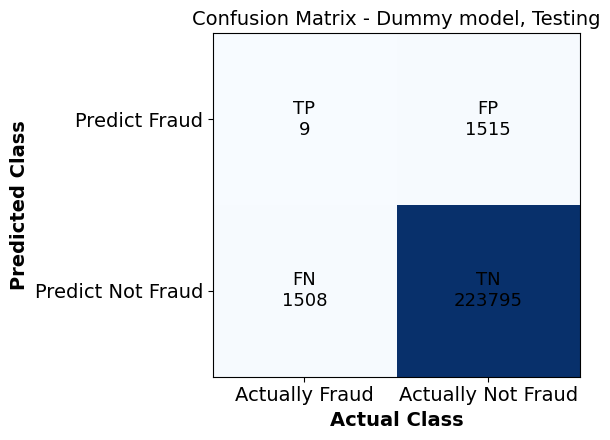

In [ ]:
# save model assessment
acc_dummy_train = get_classification_metrics(y_train_value, dummy_y_train_pred, model='Dummy', data='Training')
acc_dummy_test = get_classification_metrics(y_test_value, dummy_y_test_pred, model='Dummy', data='Testing')

# Print classification report
print('Training data: ', classification_report(y_train_value, dummy_y_train_pred))
print('Testing data: ', classification_report(y_test_value, dummy_y_test_pred))

# Plot confusion matrix
display_confusion_matrix(y_train_value, dummy_y_train_pred, 'Dummy', 'Training')
display_confusion_matrix(y_test_value, dummy_y_test_pred, 'Dummy', 'Testing')


Takeaway:
* Even with "stratified" strategy, this dummy classifer performs very poor on imblanced fraud data.
* Precision, recall, and F1-scores for class 1 (fraud) are near 0.01, indicating the classifier fails to effectively identify fraudulent cases.
* Metrics for class 0 (non-fraud) are near 0.99, as the majority class dominates predictions.
* The model can captured the true negatives, but able to detect true positives.


In [ ]:
#define the function used to
def get_scores_1(name, true, predict):
    ps = precision_score(true, predict)
    rs = recall_score(true, predict)
    f1 = f1_score(true, predict)

    ps_0 = precision_score(true, predict, pos_label=0)
    rs_0 = recall_score(true, predict, pos_label=0)
    f1_0 = f1_score(true, predict, pos_label=0)

    return pd.DataFrame({
        'Model': [name],
        'Precision_Fraud': [ps],
        'Recall_Fraud': [rs],
        'F1_Fraud': [f1],
        'Precision_NonFraud': [ps_0],
        'Recall_NonFraud': [rs_0],
        'F1_NonFraud': [f1_0]
    })


In [ ]:
dummy_df = get_scores_1('base_dummy', y_test_value, dummy_y_test_pred)
dummy_before = get_scores_1('base_dummy_before', y_test_value, dummy_y_test_pred)

In [ ]:
dummy_df

,Model,Precision_Fraud,Recall_Fraud,F1_Fraud,Precision_NonFraud,Recall_NonFraud,F1_NonFraud
0,base_dummy,0.005906,0.005933,0.005919,0.993307,0.993276,0.993291


## **4.2** Principle component analysis (PCA)


Using Principal Component Analysis (PCA) to plot fraud data is beneficial for visualizing and analyzing high-dimensional datasets. Fraud detection datasets often have many features, and PCA helps reduce the dimensionality while retaining the most informative parts of the data.
* Dimensionality Reduction --
Fraud detection datasets can contain dozens or hundreds of features. PCA reduces these features to a smaller number of principal components, capturing most of the variance (information) in the data. This makes it easier to visualize the data in 2D or 3D, enabling exploratory data analysis.
*  Identifying Patterns --
Fraudulent and non-fraudulent transactions may cluster or separate when visualized using PCA. This could help us to identify: Relationships or separations between fraud and non-fraud cases. Potential outliers or anomalies that might indicate fraud.


### **4.2.1** Plot and view data in lower dimensional space

In [ ]:
from sklearn.decomposition import PCA

def plot_pca(X, y, n_components=2):
    """
    Creates a PCA plot for the given data.

    Parameters:
    X (array-like): Feature matrix.
    y (array-like): Labels corresponding to the data points.
    n_components (int): Number of PCA components to use for the plot (default is 2).

    Returns:
    None: Displays the PCA scatter plot.
    """
    # Convert inputs to NumPy arrays if not already
    X = np.array(X)
    y = np.array(y)

    # Step 1: Apply PCA
    pca = PCA(n_components=n_components)
    X_pca = pca.fit_transform(X)

    # Step 2: Prepare for Plotting
    unique_labels = np.unique(y)
    colors = plt.cm.tab10(np.linspace(0, 1, len(unique_labels)))  # Generate distinct colors for each class

    plt.figure(figsize=(7, 6.5))

    # Step 3: Plot Each Class
    for label, color in zip(unique_labels, colors):
        plt.scatter(
            X_pca[y == label, 0],  # PCA component 1
            X_pca[y == label, 1],  # PCA component 2
            color=color,
            label=f"Fraud {label}",
            alpha=0.7,  # Transparency for overlapping points
            edgecolors="k"  # Black border for better visibility
        )

    plt.xlabel("Principal Component 1", fontsize=14)
    plt.ylabel("Principal Component 2", fontsize=14)
    plt.tick_params(axis='both', which='major', labelsize=14)
    plt.title("PCA - First Two Principal Components", fontsize=14)
    plt.legend()
    plt.grid(alpha=0.3)
    plt.show()


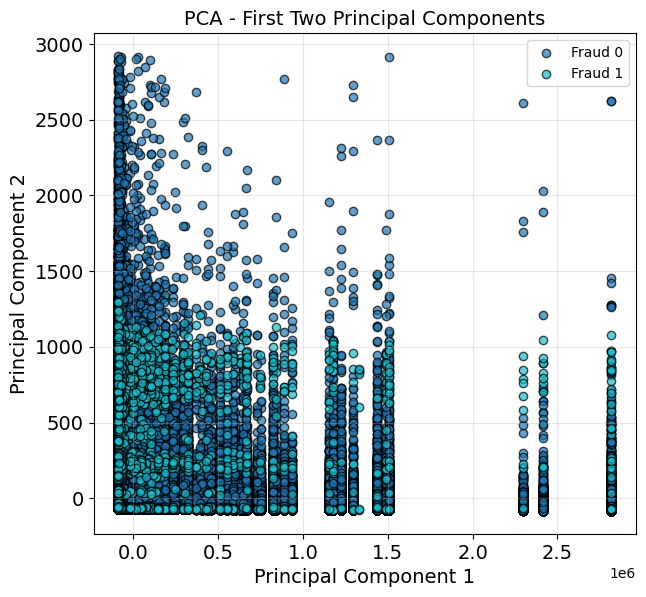

In [ ]:
plot_pca(X, y, n_components=3)

Takeaway:
* From the PCA analysis, when using all features and reduce them to 3 principle components, the fraud cases (1) and non-fraud cases (0) are not able to split well in the PCA space.
* It indicates that these two or three principal components alone may not effectively distinguish the fraud cases from the non-fraud ones. Increasing the number of components in downstream analysis could improve separation.
* It may indicate that the full set of features does not sufficiently separate cases from non-cases, and including more features might introduce additional noise rather than improving the model's performance. So we could improve the model by re-fitting it after filtering out insignificant features.



### **4.2.2** Use PCA to build logistic regression
Build apply PCA to clustering and predict is_fraud. See
[Reference](https://www.geeksforgeeks.org/principal-component-analysis-with-python/) here.

Since the principle components can capture majority information of the data, to run model efficiently with lower dimension and not loose important information, we fit and select number components and set as 10 based on previous PCA plot.

- Since the principle components retain the majority of information, they capture the most significant variance in the dataset, which can preserve the most critical information for modeling.
- Computational Efficiency: To run model efficiently with lower dimension and not loose important information, we fit and select number components and set as 10 based on previous PCA plot, while avoiding the computational overhead of high-dimensional data.
- Another potential benefit is that we can avoid overfitting: Lower dimensions reduce the model's chances of learning noise or irrelevant patterns in the data.

However there are also some limitations of using PCs to build multivariate logistic regression:
1. Loss of Interpretability: PCA components are linear combinations of original features, making it harder to directly interpret the logistic regression coefficients.
2. Potential Loss of Information: PCA retains most variance but may lose small but significant details relevant to rare events like fraud.


In [ ]:
# Applying PCA function on training and testing set of X component
from sklearn.decomposition import PCA

pca = PCA(n_components=10)

X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)

explained_variance = pca.explained_variance_ratio_


In [ ]:
# Check variance of the components that the model explained
explained_variance

array([0.33684232, 0.09883388, 0.09490913, 0.07611767, 0.06996995,
       0.06948319, 0.063937  , 0.01928284, 0.01757123, 0.0159378 ])

In [ ]:
# Fitting Logistic Regression To the training set

pca_mlr = LogisticRegression(random_state=42)
pca_mlr.fit(X_train_pca, y_train)

LogisticRegression(random_state=42)

### **4.2.3** Predict and evaluate model performance


In [ ]:
# Predicting the test set result
pcamlr_y_train_pred = pca_mlr.predict(X_train_pca)
pcamlr_y_test_pred = pca_mlr.predict(X_test_pca)


Training data:                precision    recall  f1-score   support

           0       0.99      1.00      1.00    901344
           1       0.28      0.06      0.10      5964

    accuracy                           0.99    907308
   macro avg       0.64      0.53      0.55    907308
weighted avg       0.99      0.99      0.99    907308

Testing data:                precision    recall  f1-score   support

           0       0.99      1.00      1.00    225310
           1       0.29      0.06      0.10      1517

    accuracy                           0.99    226827
   macro avg       0.64      0.53      0.55    226827
weighted avg       0.99      0.99      0.99    226827



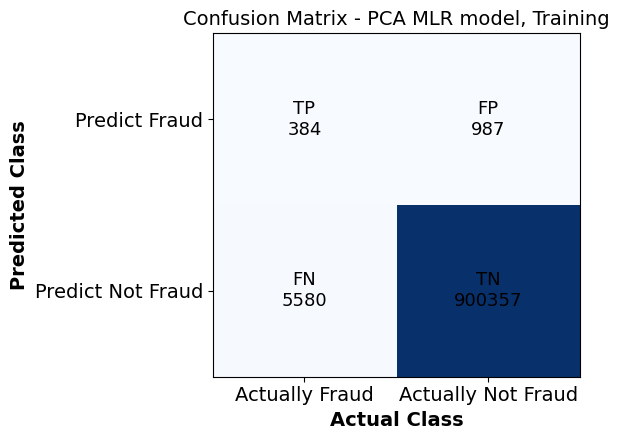

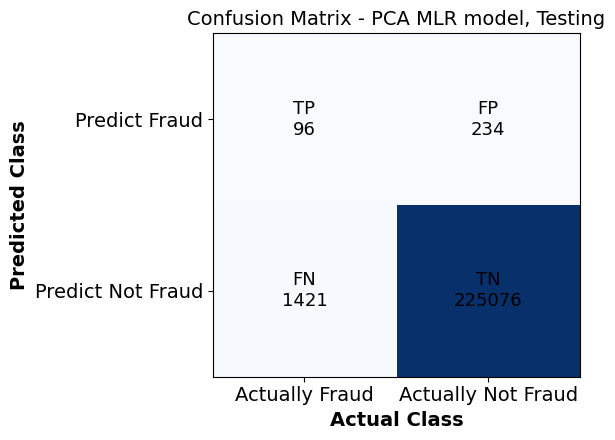

In [ ]:
# save model assessment
acc_pcamlr_train = get_classification_metrics(y_train_value, pcamlr_y_train_pred, model='PCA MLR', data='Training')
acc_pcamlr_test = get_classification_metrics(y_test_value, pcamlr_y_test_pred, model='PCA MLR', data='Testing')

# Print classification report
print('Training data: ', classification_report(y_train_value, pcamlr_y_train_pred))
print('Testing data: ', classification_report(y_test_value, pcamlr_y_test_pred))

display_confusion_matrix(y_train_value, pcamlr_y_train_pred, 'PCA MLR', 'Training')
display_confusion_matrix(y_test_value, pcamlr_y_test_pred, 'PCA MLR', 'Testing')


Takeaway:
* Using princeple components to run logistic regression, it improved precision, recall and F1 score comparing with dummy variables. But this model still does not perform well.
* Similar to dummy variable, all precision, recall, F1-score are aroung 0.99 for non-fraud cases, indicating the model is very accurate in predicting non-fraud cases.
* The precisions are only 0.27 for training and 0.29 for testing data, meaning that only <30% of predicted fraud cases are correct.
* The the recall is very low at 0.06 for training and 0.07 for testing data, meaning the model misses >90% of actual fraud cases.
* F1-score is only in range ~0.1, highlighting poor overall performance on fraud cases which is 1.



In [ ]:
pca_mlr_df = get_scores_1('pca_mlr', y_test_value, pcamlr_y_test_pred)
pca_mlr_before = get_scores_1('pca_mlr_before', y_test_value, pcamlr_y_test_pred)

## **4.3** Weighted Multivariate logistics regression with L2 regularization


Weighted Multivariate Logistic Regression (WMLR) with L2 regularization is often used in fraud detection because it effectively addresses the challenges of imbalanced datasets and avoids overfitting, while maintaining interpretability and efficiency.

We apply multivariate logistic regression with L2 regularization to model the
binary outcome (fraud 0 vs. non-fraud 1).
There're several reasons that we choose this model:
* Handles Imbalanced Datasets with Weighted Loss --
Fraud detection datasets typically have a small number of fraudulent cases compared to legitimate ones.
With setting class_weight = "balanced", the model will address the imbalanced information of this fraud datasets. WMLR assigns higher weights to minority class (Fraud), which ensures the model prioritizes correctly classifying fraudulent cases.
* The model Balances Precision and Recall --
It helps reduce the tendency of standard logistic regression to favor the majority class, improving detection of minority class instances.
*  Incorporates Regularization to Prevent Overfitting --
By using L2 Regularization (Ridge Regression), the model adds a penalty term proportional to the squared magnitude of coefficients, and shrinks less important feature coefficients towards zero. So the model can prevents the model from overfitting noisy or irrelevant features, and it makes the model generalize better to unseen data.
* Robustness to Multicollinearity --
The L2 regularization reduces the impact of correlated features by distributing weights more evenly, which can prevents overemphasis on redundant features. And it stabilizes the model in datasets with highly correlated variables.
* Interpretability --
Multivariate Logistic regression is inherently interpretable:
Coefficients indicate the direction (positive or negative) and magnitude of a feature's effect on the probability of fraud. Weighted and regularized logistic regression maintains this interpretability while addressing imbalance and overfitting.
* Simplicity and Scalability --
Computationally efficient and scales well to large datasets, even with many features.

### **4.3.1** Fitting model

In [ ]:
# Create a class-weighted logistic, the model using Regularization, setting strength of penalty as 1
wmlg = LogisticRegression(class_weight='balanced', penalty='l2')
# wmlg = LogisticRegression(class_weight='balanced', penalty='l2', C=1, solver='saga')
# wmlg = LogisticRegression(class_weight='balanced', penalty='l2', C=1, solver='saga', max_iter=1000)
# Train the model
wmlg.fit(X_train, y_train)


LogisticRegression(class_weight='balanced')

### **4.3.2** Prediction and model evaluation


In [ ]:
# Make predictions - weighted multivariate logistic regression
wmlg_y_train_pred = wmlg.predict(X_train)
wmlg_y_test_pred = wmlg.predict(X_test)


Training data:                precision    recall  f1-score   support

           0       1.00      0.87      0.93    901344
           1       0.04      0.81      0.07      5964

    accuracy                           0.87    907308
   macro avg       0.52      0.84      0.50    907308
weighted avg       0.99      0.87      0.92    907308

Testing data:                precision    recall  f1-score   support

           0       1.00      0.87      0.93    225310
           1       0.04      0.80      0.07      1517

    accuracy                           0.87    226827
   macro avg       0.52      0.83      0.50    226827
weighted avg       0.99      0.87      0.92    226827



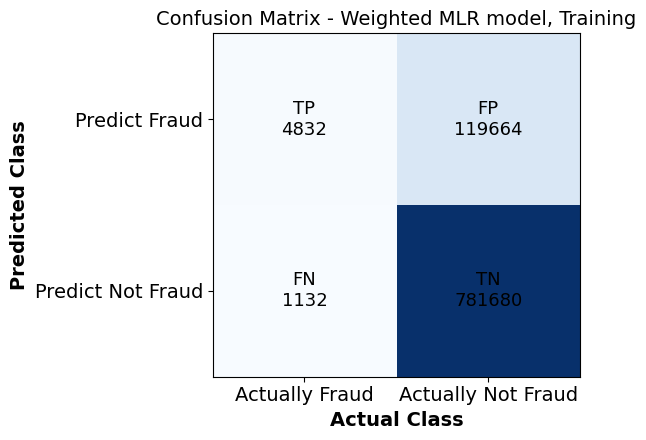

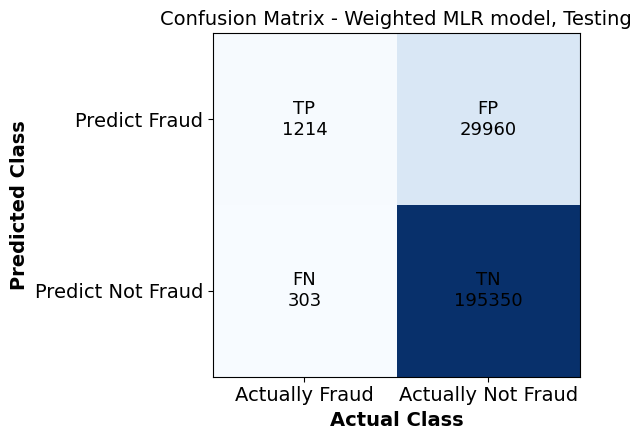

In [ ]:
# save model assessment
acc_wmlg_train = get_classification_metrics(y_train_value, wmlg_y_train_pred, model='Weighted MLR', data='Training')
acc_wmlg_test = get_classification_metrics(y_test_value, wmlg_y_test_pred, model='Weighted MLR', data='Testing')

# Print classification report
print('Training data: ', classification_report(y_train_value, wmlg_y_train_pred))
print('Testing data: ', classification_report(y_test_value, wmlg_y_test_pred))

# Plot confusion matrix
display_confusion_matrix(y_train_value, wmlg_y_train_pred, 'Weighted MLR', 'Training')
display_confusion_matrix(y_test_value, wmlg_y_test_pred, 'Weighted MLR', 'Testing')


Takeaway:

* The multivariate logistic regression showed improvements on recall measurements 0.81 for training and 0.83 for testing data, meaning the model has dramatic improvements on capturing real fraud cases.
* However, the precision is very low, only ~0.04, meaning the only 4% of predicted fraud cases are true fraud cases, there're a lot of false positives. Similar for F1-score.
* Overall, the model over-predict fraud cases, which may lead many false positive alert.



We apply multivariate logistic regression with L2 regularization to model the binary outcome (fraud 0 vs. non-fraud 1). By setting class_weight = "balanced", the model will address the imbalanced information of this fraud datasets.

In [ ]:
wmlr_df = get_scores_1('weighted_mlr', y_test, wmlg_y_test_pred)
wmlr_before = get_scores_1('weighted_mlr_before', y_test, wmlg_y_test_pred)


## **4.4** Random Forest

Random Forest is a powerful ensemble machine learning algorithm that combines the predictions of multiple decision trees to produce accurate and stable results. We use it in fraud detection for several reasons:

* Handling Imbalanced Data --
Our fraud detection dataset is highly imbalanced, with fraudulent transactions making up a tiny fraction of all transactions. Random Forest can handle imbalanced datasets effectively. Use bootstrapping and random sampling to ensure minority class data contributes effectively to the learning process.
* Robustness to Overfitting --
By constructing a multitude of decision trees and aggregating their results, Random Forest reduces the risk of overfitting that individual decision trees might exhibit. This ensemble method ensures the model generalizes well to unseen data, which is crucial in fraud detection where new fraud patterns emerge constantly.
* Robustness to Noise and Outliers --
The algorithm is less sensitive to noise and outliers due to the aggregation of multiple trees.
* Ability to Capture Complex Patterns --
Fraud often involves subtle and non-linear patterns. Random Forest:
Uses non-linear decision boundaries. Captures intricate relationships between features without extensive pre-processing.
* Feature Importance Estimation --
Random Forest provides measures of feature importance, helping identify which factors contribute most to predicting fraud. Its capability aids in feature selection and understanding underlying fraud mechanisms, enhancing both model performance and interpretability.


### **4.4.1** Fitting model

In [ ]:
# Initialize the RandomForestClassifier with the above parameters
SEED = 42
rfc = RandomForestClassifier(class_weight = 'balanced', n_estimators = 50, max_depth = 10, random_state = SEED)

# Fit it to the training set
rfc.fit(X_train, y_train)

RandomForestClassifier(class_weight='balanced', max_depth=10, n_estimators=50,
                       random_state=42)

### **4.4.2** Prediction and model evaluation


In [ ]:
# Predict on the training and testing set
rfc_y_train_pred = rfc.predict(X_train)
rfc_y_test_pred = rfc.predict(X_test)

Training data:                precision    recall  f1-score   support

           0       1.00      0.98      0.99    901344
           1       0.20      0.93      0.33      5964

    accuracy                           0.98    907308
   macro avg       0.60      0.95      0.66    907308
weighted avg       0.99      0.98      0.98    907308

Testing data:                precision    recall  f1-score   support

           0       1.00      0.98      0.99    225310
           1       0.19      0.88      0.32      1517

    accuracy                           0.97    226827
   macro avg       0.60      0.93      0.65    226827
weighted avg       0.99      0.97      0.98    226827



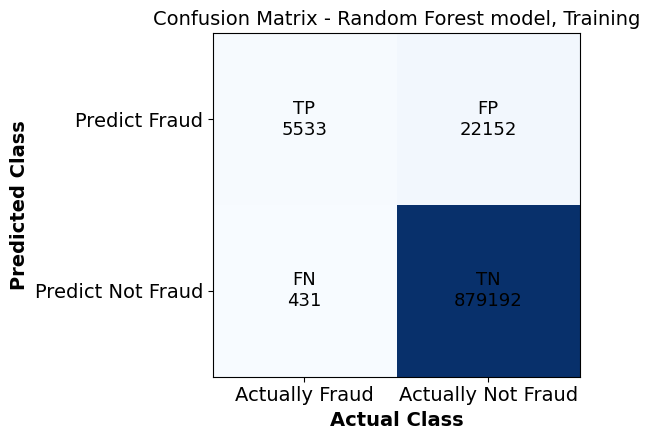

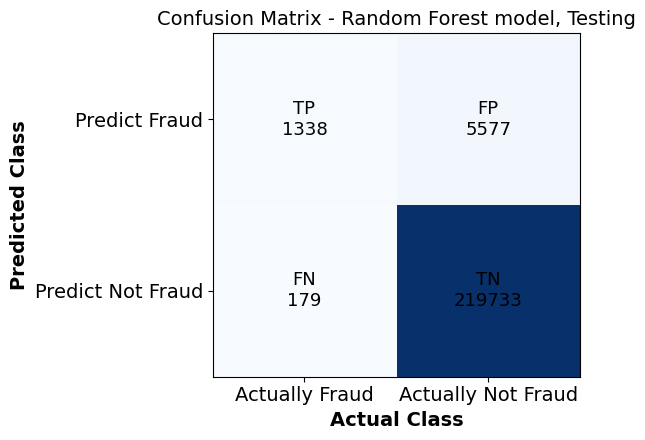

In [ ]:
# save model assessment
acc_rfc_train = get_classification_metrics(y_train_value, rfc_y_train_pred, model='Random Forest', data='Training')
acc_rfc_test = get_classification_metrics(y_test_value, rfc_y_test_pred, model='Random Forest', data='Testing')

# Print classification report
print('Training data: ', classification_report(y_train_value, rfc_y_train_pred))
print('Testing data: ', classification_report(y_test_value, rfc_y_test_pred))

# Plot confusion matrix
display_confusion_matrix(y_train_value, rfc_y_train_pred, 'Random Forest', 'Training')
display_confusion_matrix(y_test_value, rfc_y_test_pred, 'Random Forest', 'Testing')


In [ ]:
rfc_pd = get_scores_1('rfc', y_test, rfc_y_test_pred)
rfc_before = get_scores_1('rfc_before', y_test, rfc_y_test_pred)


### **4.4.3** Identify feature importances


In [ ]:
# Extract Feature importances and save to a data frame
feature_names = X.columns.tolist()
importance_df = pd.DataFrame({
    'Features': feature_names,
    'importance': rfc.feature_importances_
})


In [ ]:
importance_df.sort_values('importance', ascending=False).head(10)


,Features,importance
31,amt,0.591817
2,day_period,0.222696
14,mercant_category_shopping,0.043693
11,mercant_category_home,0.020706
28,age,0.020036
12,mercant_category_leisure,0.014331
9,mercant_category_grocery,0.014325
8,mercant_category_gas,0.011256
30,city_pop,0.011060
29,distance_km,0.008735


Takeaway:
* The Random Forest model dramatically improve the model. In all precision, recall and f1-score measurement.
* It can capture most true fraud cases, even though it still captured many false positive cases.
* Recall (ability to identify true frauds) is high, showing the model’s robustness in catching most fraudulent transactions.
* Precision needs improvement as the model predicts too many false positives (fraudulent cases that are actually not fraud). This could lead to unnecessary customer disruptions.
* True Positives (TP): The Random Forest model effectively captures true fraud cases (e.g., 1,338 in testing and 5,533 in training). This demonstrates its ability to identify fraudulent transactions.
* False Positives (FP): The model still predicts many transactions as fraudulent when they are not (e.g., 5,577 in testing and 22,152 in training). This indicates room for improvement in precision, as excessive false positives may inconvenience customers.

* Feature importance -- From the model, we can see the amt is identified as an very significant indicator for predicting the fraud. High or unusual transaction amounts likely trigger fraud detection. The day_period is second important feature, the fraud transitions more likely happened in midnight.


### **4.4.4** Hyperparameter tuning

In [ ]:
SEED = 42

# Define the stratified cross-validation splitter with the above seed
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=SEED)

# Define the RandomForestClassifier with the above seed
estimator = RandomForestClassifier(random_state=SEED)

# Define the parameter grid
param_grid = {
    'class_weight': [None, 'balanced'],
    'n_estimators': [50, 100, 120],
    'max_depth': [5, 10, 20]
}

# Define the metric as a lower case string (e.g. scoring = 'accuracy')
scoring = 'recall'

In [ ]:
# Set up the grid search
search = GridSearchCV(estimator=estimator, param_grid=param_grid, scoring=scoring, cv=cv, verbose=2)

# Execute the grid search by calling fit
search.fit(X_train, y_train)


Fitting 5 folds for each of 18 candidates, totalling 90 fits
[CV] END ....class_weight=None, max_depth=5, n_estimators=50; total time=  29.1s
[CV] END ....class_weight=None, max_depth=5, n_estimators=50; total time=  29.3s
[CV] END ....class_weight=None, max_depth=5, n_estimators=50; total time=  36.2s
[CV] END ....class_weight=None, max_depth=5, n_estimators=50; total time=  35.0s
[CV] END ....class_weight=None, max_depth=5, n_estimators=50; total time=  30.0s
[CV] END ...class_weight=None, max_depth=5, n_estimators=100; total time= 1.0min
[CV] END ...class_weight=None, max_depth=5, n_estimators=100; total time=  56.8s
[CV] END ...class_weight=None, max_depth=5, n_estimators=100; total time=  58.2s
[CV] END ...class_weight=None, max_depth=5, n_estimators=100; total time=  58.9s
[CV] END ...class_weight=None, max_depth=5, n_estimators=100; total time=  56.7s
[CV] END ...class_weight=None, max_depth=5, n_estimators=120; total time= 1.2min
[CV] END ...class_weight=None, max_depth=5, n_es

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
             estimator=RandomForestClassifier(random_state=42),
             param_grid={'class_weight': [None, 'balanced'],
                         'max_depth': [5, 10, 20],
                         'n_estimators': [50, 100, 120]},
             scoring='recall', verbose=2)

In [ ]:
# Capture the best model
print(f'The best Random Forest model has hyperparameters {search.best_params_}')
# print(f'The best model achieves an average cross-validation score of {search.best_score_*100:.2f}%')


The best Random Forest model has hyperparameters {'class_weight': 'balanced', 'max_depth': 10, 'n_estimators': 120}


### **4.4.5** Refit model with best hyperparameters

In [ ]:
# Initialize the RandomForestClassifier with the above parameters
SEED = 42
rfc_refit = RandomForestClassifier(class_weight = 'balanced', n_estimators = 120, max_depth = 10, random_state = SEED)

# Fit it to the training set
rfc_refit.fit(X_train, y_train)

RandomForestClassifier(class_weight='balanced', max_depth=10, n_estimators=120,
                       random_state=42)

In [ ]:
# Predict on the training and testing set
rfc_refit_y_train_pred = rfc_refit.predict(X_train)
rfc_refit_y_test_pred = rfc_refit.predict(X_test)

Training data:                precision    recall  f1-score   support

           0       1.00      0.98      0.99    901344
           1       0.20      0.93      0.33      5964

    accuracy                           0.98    907308
   macro avg       0.60      0.95      0.66    907308
weighted avg       0.99      0.98      0.98    907308

Testing data:                precision    recall  f1-score   support

           0       1.00      0.98      0.99    225310
           1       0.19      0.89      0.32      1517

    accuracy                           0.97    226827
   macro avg       0.60      0.93      0.65    226827
weighted avg       0.99      0.97      0.98    226827



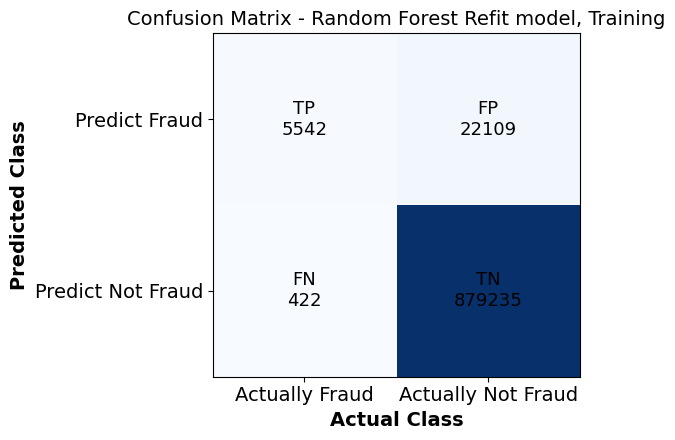

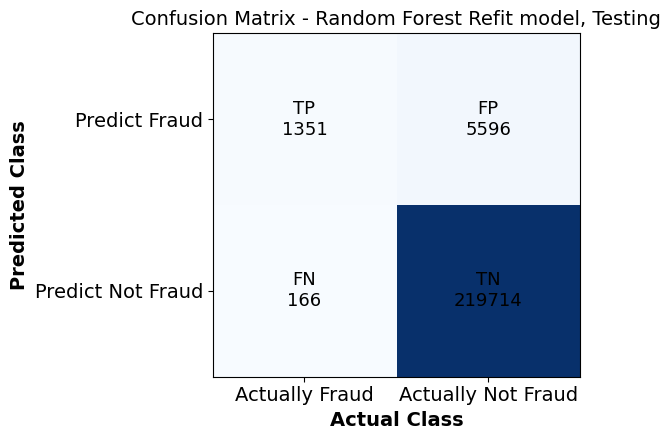

In [ ]:
# save model assessment
acc_rfc_refit_train = get_classification_metrics(y_train_value, rfc_refit_y_train_pred, model='Random Forest Refit', data='Training')
acc_rfc_refit_test = get_classification_metrics(y_test_value, rfc_refit_y_test_pred, model='Random Forest Refit', data='Testing')

# Print classification report
print('Training data: ', classification_report(y_train_value, rfc_refit_y_train_pred))
print('Testing data: ', classification_report(y_test_value, rfc_refit_y_test_pred))

# Plot confusion matrix
display_confusion_matrix(y_train_value, rfc_refit_y_train_pred, 'Random Forest Refit', 'Training')
display_confusion_matrix(y_test_value, rfc_refit_y_test_pred, 'Random Forest Refit', 'Testing')


In [ ]:
rfc_refit_pd = get_scores_1('rfc_refit', y_test, rfc_refit_y_test_pred)
rfc_refit_before = get_scores_1('rfc_before', y_test, rfc_refit_y_test_pred)


## **4.5** XGBoost

XGBoost (eXtreme Gradient Boosting) is a powerful machine learning algorithm that is widely used due to its accuracy, flexibility, and ability to handle the unique challenges posed by fraud datasets. Here're several reasons that we choose XGBoost for our fraud detection data:
* Excellent Performance on Imbalanced Datasets --
As we saw in early sessions, the fraud detection datasets are highly imbalanced, with fraudulent transactions being much fewer than legitimate ones. XGBoost can:
Handle imbalances effectively by adjusting the scale of positive and negative weights using the scale_pos_weight parameter. It prioritize capturing the minority class (fraud) without sacrificing overall performance.
* High Predictive Accuracy --
XGBoost uses an ensemble of decision trees and gradient boosting to minimize errors iteratively. This allows it to:
Learn complex patterns in the data, even when fraudulent cases are subtle.
The XGBoost model usually outperform many traditional machine learning models in terms of accuracy and recall.
* Ability to Handle Noisy and Sparse Data --
Fraud data often contains noise or missing values. XGBoost handles such data effectively through: automatic feature selection and pruning of irrelevant features. So it can robustly handle of sparse matrices.
* Feature Importance --
XGBoost provides a feature importance ranking, which helps use to identify and intepret the most influential factors in fraud detection (e.g., transaction amount, location, time).

### **4.5.1** Fitting model

In [ ]:
# Find the ratio of imbalanced classes
class_ratio = np.sum(y_train == 0) / np.sum(y_train == 1)
class_ratio

151.1307847082495

In [ ]:

# Initialize XGBClassifier with the above class ratio
xgb = XGBClassifier(random_state = SEED, tree_method = 'hist', scale_pos_weight = class_ratio, n_estimators = 50)

# Fit the classifier to our data
xgb.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=50, n_jobs=None,
              num_parallel_tree=None, random_state=42, ...)

### **4.5.2** Prediction and model evaluation


In [ ]:
# Prediction using the XGB classifier
xgb_y_train_pred = xgb.predict(X_train)
xgb_y_test_pred = xgb.predict(X_test)


Training data:                precision    recall  f1-score   support

           0       1.00      0.98      0.99    901344
           1       0.24      0.99      0.38      5964

    accuracy                           0.98    907308
   macro avg       0.62      0.99      0.68    907308
weighted avg       0.99      0.98      0.99    907308

Testing data:                precision    recall  f1-score   support

           0       1.00      0.98      0.99    225310
           1       0.23      0.94      0.37      1517

    accuracy                           0.98    226827
   macro avg       0.61      0.96      0.68    226827
weighted avg       0.99      0.98      0.98    226827



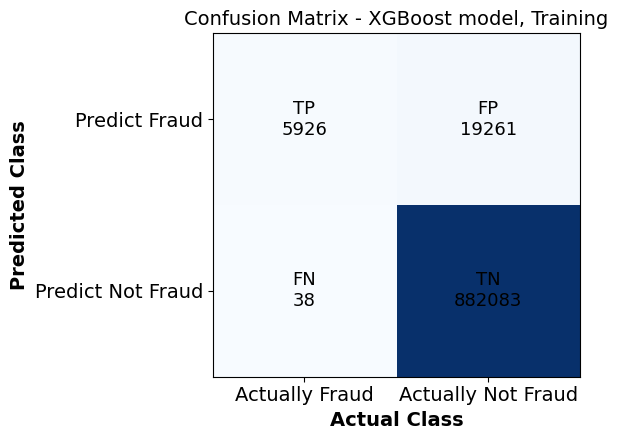

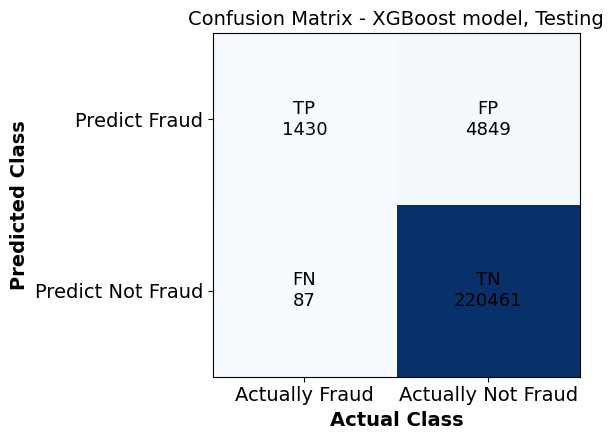

In [ ]:
# save model assessment
acc_xgb_train = get_classification_metrics(y_train_value, xgb_y_train_pred, model='XGBoost', data='Training')
acc_xgb_test = get_classification_metrics(y_test_value, xgb_y_test_pred, model='XGBoost', data='Testing')

# Print classification report
print('Training data: ', classification_report(y_train_value, xgb_y_train_pred))
print('Testing data: ', classification_report(y_test_value, xgb_y_test_pred))

# Plot confusion matrix
display_confusion_matrix(y_train_value, xgb_y_train_pred, 'XGBoost', 'Training')
display_confusion_matrix(y_test_value, xgb_y_test_pred, 'XGBoost', 'Testing')


In [ ]:
xgboost_pd = get_scores_1('xgboost', y_test, xgb_y_test_pred)
xgboost_before = get_scores_1('xgboost_before', y_test, xgb_y_test_pred)


### **4.5.3** Identify feature importance

In [ ]:
# Extract Feature importances and save to a data frame
feature_names = X.columns.tolist()
importance_df = pd.DataFrame({
    'Features': feature_names,
    'importance': xgb.feature_importances_
})


In [ ]:
importance_df.sort_values('importance', ascending=False).head(10)

,Features,importance
31,amt,0.240207
14,mercant_category_shopping,0.138036
8,mercant_category_gas,0.125849
2,day_period,0.090391
9,mercant_category_grocery,0.070774
13,mercant_category_misc,0.047045
12,mercant_category_leisure,0.037229
11,mercant_category_home,0.033166
10,mercant_category_health,0.022318
28,age,0.015646


### **4.5.4** Hyperparamater tuning

In [ ]:
SEED = 42

# Define the stratified cross-validation splitter with the above seed
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=SEED)

# Define the RandomForestClassifier with the above seed
estimator = XGBClassifier(random_state=SEED)

# Define the parameter grid
param_grid = {
    'n_estimators': [50, 100, 120],
    'scale_pos_weight': [1, 50, 100, 200]
}

# Define the metric to tune for model
scoring = 'f1'

In [ ]:
# Set up the grid search
search = GridSearchCV(estimator=estimator, param_grid=param_grid, scoring=scoring, cv=cv, verbose=2)

# Execute the grid search by calling fit
search.fit(X_train, y_train)


Fitting 5 folds for each of 12 candidates, totalling 60 fits
[CV] END ................n_estimators=50, scale_pos_weight=1; total time=   6.3s
[CV] END ................n_estimators=50, scale_pos_weight=1; total time=   9.2s
[CV] END ................n_estimators=50, scale_pos_weight=1; total time=   6.0s
[CV] END ................n_estimators=50, scale_pos_weight=1; total time=   9.2s
[CV] END ................n_estimators=50, scale_pos_weight=1; total time=   6.5s
[CV] END ...............n_estimators=50, scale_pos_weight=50; total time=  26.4s
[CV] END ...............n_estimators=50, scale_pos_weight=50; total time=  16.0s
[CV] END ...............n_estimators=50, scale_pos_weight=50; total time=   9.6s
[CV] END ...............n_estimators=50, scale_pos_weight=50; total time=  13.5s
[CV] END ...............n_estimators=50, scale_pos_weight=50; total time=   6.1s
[CV] END ..............n_estimators=50, scale_pos_weight=100; total time=   9.3s
[CV] END ..............n_estimators=50, scale_po

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     grow_policy=None, importance_typ...
                                     learning_rate=None, max_bin=None,
                                     max_cat_threshold=None,
                                     max_cat_to_onehot=None,
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=None,
                                     n_jobs=None, num_parallel_tree=None,
                                     random_state=42, ...),
             param_grid={'n_estimators': [50, 100, 120],
                         'scale_pos_weight': [1, 50, 100, 200]},
             scoring='f1', verbose=2)

In [ ]:
# Capture the best model
print(f'The best XGBoost model has hyperparameters {search.best_params_}')
print(f'The best model achieves an average cross-validation score of {search.best_score_*100:.2f}%')


The best XGBoost model has hyperparameters {'n_estimators': 120, 'scale_pos_weight': 1}
The best model achieves an average cross-validation score of 80.51%


### **4.5.5** Refit model with best hyperparameters

In [ ]:

# Initialize XGBClassifier with the above class ratio
xgb_refit_clf = XGBClassifier(random_state = SEED, tree_method = 'hist', scale_pos_weight = 1, n_estimators = 120)

# Fit the classifier to our data
xgb_refit_clf.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=120, n_jobs=None,
              num_parallel_tree=None, random_state=42, ...)

In [ ]:
# Prediction using the XGB classifier
xgb_refit_clf_y_train_pred = xgb_refit_clf.predict(X_train)
xgb_refit_clf_y_test_pred = xgb_refit_clf.predict(X_test)


Training data:                precision    recall  f1-score   support

           0       1.00      1.00      1.00    901344
           1       0.94      0.83      0.88      5964

    accuracy                           1.00    907308
   macro avg       0.97      0.92      0.94    907308
weighted avg       1.00      1.00      1.00    907308

Testing data:                precision    recall  f1-score   support

           0       1.00      1.00      1.00    225310
           1       0.87      0.75      0.81      1517

    accuracy                           1.00    226827
   macro avg       0.93      0.88      0.90    226827
weighted avg       1.00      1.00      1.00    226827



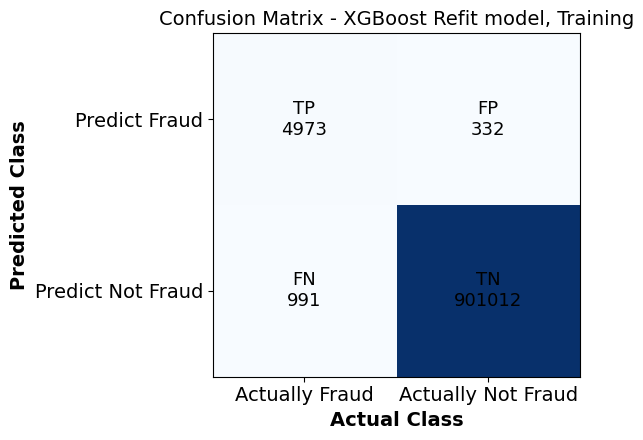

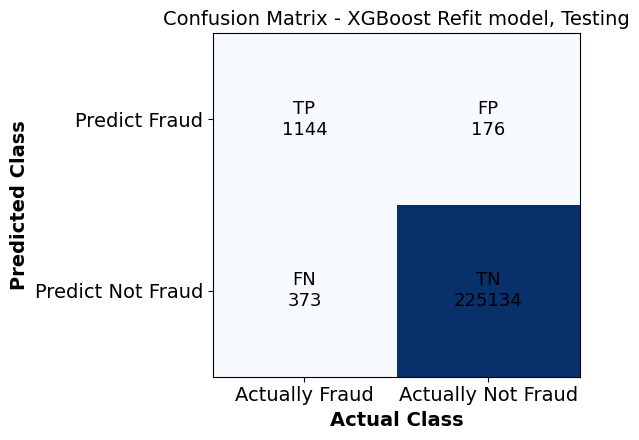

In [ ]:
# save model assessment
acc_xgb_refit_train = get_classification_metrics(y_train_value, xgb_refit_clf_y_train_pred, model='XGBoost Refit', data='Training')
acc_xgb_refit_test = get_classification_metrics(y_test_value, xgb_refit_clf_y_test_pred, model='XGBoost Refit', data='Testing')

# Print classification report
print('Training data: ', classification_report(y_train_value, xgb_refit_clf_y_train_pred))
print('Testing data: ', classification_report(y_test_value, xgb_refit_clf_y_test_pred))

# Plot confusion matrix
display_confusion_matrix(y_train_value, xgb_refit_clf_y_train_pred, 'XGBoost Refit', 'Training')
display_confusion_matrix(y_test_value, xgb_refit_clf_y_test_pred, 'XGBoost Refit', 'Testing')


In [ ]:
xgboost_refit_pd = get_scores_1('xgboost_refit', y_test, xgb_refit_clf_y_test_pred)
xgboost_refit_before = get_scores_1('xgboost_before', y_test, xgb_refit_clf_y_test_pred)


## **4.6** Summary of models performance


Concatenate all model metrics and check the performance


### **4.6.1** Combine All Model Scores

In this step, we combine the performance scores (Precision, Recall, F1) of all models before and after feature selection or PCA into a single dataframe.This allows us to prepare the data for comparative visualization.

In [ ]:
# Combine all scores into a single dataframe
all_scores_df = pd.concat([
    dummy_df,
    pca_mlr_df,
    wmlr_df,
    rfc_pd,
    rfc_refit_pd,
    xgboost_pd,
    xgboost_refit_pd
], ignore_index=True)
all_scores_df

,Model,Precision_Fraud,Recall_Fraud,F1_Fraud,Precision_NonFraud,Recall_NonFraud,F1_NonFraud
0,base_dummy,0.004569,0.004614,0.004592,0.993298,0.993232,0.993265
1,pca_mlr,0.290909,0.063283,0.103952,0.993726,0.998961,0.996337
2,weighted_mlr,0.038943,0.800264,0.074271,0.998451,0.867028,0.928110
3,rfc,0.193492,0.882004,0.317362,0.999186,0.975247,0.987072
4,rfc_refit,0.194472,0.890574,0.319234,0.999245,0.975163,0.987057
5,xgboost,0.227743,0.942650,0.366855,0.999606,0.978479,0.988929
6,xgboost_refit,0.866667,0.754120,0.806486,0.998346,0.999219,0.998782


### **4.6.2** Prepare Data for Visualization

To visualize the performance metrics (Precision, Recall, F1) for all models,we reshape the dataframe into a "long" format using the melt function. This makes it easier to plot multiple metrics across all models in one figure.

In [ ]:
# Melt the dataframe for visualization
model_scores_melted = pd.melt(
    all_scores_df,
    id_vars=["Model"],  # Keep the 'Model' column
    var_name="Metric",  # Combine all metric columns (e.g., Precision_Fraud, Recall_Fraud, etc.)
    value_name="Value"  # The values for each metric
)

model_scores_melted_fraud = model_scores_melted[model_scores_melted["Metric"].str.contains("_Fraud")]

### **4.6.3** Plot Model Performance

We create a bar plot to compare the performance metrics (Precision, Recall, F1)across all models. Different metrics are displayed using different colors.


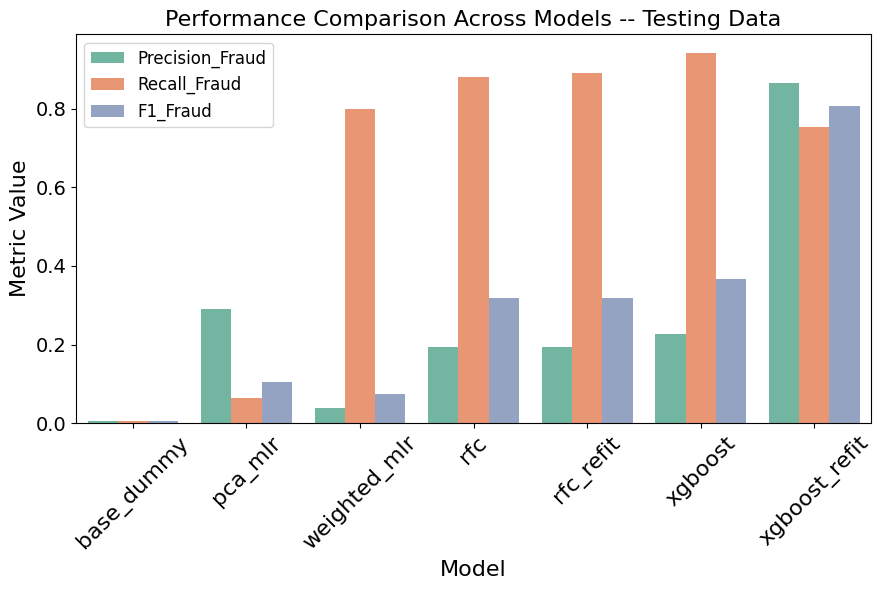

In [ ]:
# Plot the data
plt.figure(figsize=(9, 6))
sns.barplot(
    data=model_scores_melted_fraud,
    x="Model",  # Model names (e.g., rfc_pca_before, etc.)
    y="Value",  # Metric values (Precision, Recall, F1)
    hue="Metric",  # Metrics (e.g., Precision_Fraud, Recall_Fraud, F1_Fraud, etc.)
    palette="Set2"
)

# Customize the plot
plt.title("Performance Comparison Across Models -- Testing Data", fontsize=16)
plt.xlabel("Model", fontsize=16)
plt.ylabel("Metric Value", fontsize=16)
plt.xticks(rotation=45, fontsize=16)
plt.yticks(fontsize=14)
plt.legend(fontsize=12, title_fontsize=12)
plt.tight_layout()
plt.show()


**Conclusion**:
* Base Dummy model has near-zero values for all metrics. As expected, this baseline model has negligible performance metrics, confirming that it serves as a control for assessing model improvement.
* Multivariate logistic regression based on PCA only shows some improvement over the base model, with moderate precision, recall, and F1 values, but is still far from being practically useful.
* Weighted multivariate logistic regression, random forest and random forest after tunned hyperparameters provide a noticeable improvement, especially in recall meaning the models can well capture fraud cases. However, they all show very low precision and recall measurement, meaning these models predict too many false positive. Therefore, if capturing as many fraudulent cases as possible is critical, random forest model would be a reasonable choice.
* **XGBoost** after hyperparameters tunning demonstrates an impressive performance improvement, it shows highest values across metrics of Precision and F1-score, even though it slightly lower recall comparing to the model before tuning. It indicates the best model for fraud detection in this comparison. The tunned XGBoost model consistently dominates across all metrics, making it the most robust and reliable choice for fraud detection.
* In summary, the **XGBoost** model after hyperparameters tunning is the standout model, with top performance across precision, recall, and F1 metrics. It is highly recommended for deployment in fraud detection tasks due to its ability to detect fraudulent cases effectively while minimizing false positives. Basic XGBoost can be considered as a strong alternative if capturing as many fraudulent cases as possible is important.

# **Part 5:** Model Optimization - Addressing Imbalanced Data

In our data where the number of non-fraudulent cases significantly outnumbers fraudulent ones. This imbalance can bias machine learning models toward predicting the majority class, leading to poor performance in detecting fraud.

SMOTE works by generating synthetic samples for the minority class (fraud cases in this context) using a k-nearest neighbors approach. It creates new data points by interpolating between existing minority class samples, thereby increasing the representation of fraud cases in the dataset. By applying SMOTE, we can train models on a more balanced dataset, improving their ability to identify fraudulent transactions without being overwhelmed by the majority class. This ensures a more robust and reliable fraud detection system.

In [ ]:
#helper function to get a dataframe of differet scores

def get_scores(name, true, predict):
  ps = precision_score(true, predict)
  rs = recall_score(true, predict)
  f1 = f1_score(true, predict)

  ps_0 = precision_score(true, predict, pos_label=0)
  rs_0 = recall_score(true, predict, pos_label=0)
  f1_0 = f1_score(true, predict, pos_label=0)

  return pd.DataFrame({'': ['precision', 'recall', 'f1'], name+'-(fraud)': [ps, rs, f1], name+'-(non_fraud)':[ps_0, rs_0, f1_0]})

### **5.1** SMOTE Implementation


#### **5.1.1** Understand The Data Imbalance

In [ ]:
# get the nparry from previous modeling and rename
X_sm_train = X_train_values
y_sm_train = y_train_value
X_sm_test = X_test_value
y_sm_test = y_test_value

In [ ]:
# create a dictionary to understand the data imbalance
unique, count = np.unique(y_train_value, return_counts = True)
y_train_dict_value_count = {k:v for k, v in zip(unique, count)}
y_train_dict_value_count

{0: 901344, 1: 5964}

Key Takeaways

This means that class 0 dominates the dataset, accounting for about 99.3% of the data, while class 1 represents only about 0.7%. This is a classic example of a highly imbalanced dataset.

#### **5.1.2** Base Logistic Model
With default SMOTE parameters

In [ ]:
# Initialize SMOTE and fit training data
sm = SMOTE(random_state=42)
X_train_res, y_train_res = sm.fit_resample(X_sm_train, y_sm_train)

In [ ]:
# Check the data imbalance
unique, count = np.unique(y_train_res, return_counts = True)
y_train_dict_res_count = {k:v for k, v in zip(unique, count)}
y_train_dict_res_count

{0: 901344, 1: 901344}

Key Takeaways

After applying SMOTE, both classes now have an equal number of samples. This eliminates the imbalance present in the original dataset.

In [ ]:
# fit logistic model
clf = LogisticRegression().fit(X_train_res, y_train_res)

Training data: 
               precision    recall  f1-score   support

           0       0.82      0.87      0.85    901344
           1       0.86      0.82      0.84    901344

    accuracy                           0.84   1802688
   macro avg       0.84      0.84      0.84   1802688
weighted avg       0.84      0.84      0.84   1802688
 
Testing data: 
               precision    recall  f1-score   support

           0       1.00      0.87      0.93    225310
           1       0.04      0.80      0.07      1517

    accuracy                           0.87    226827
   macro avg       0.52      0.84      0.50    226827
weighted avg       0.99      0.87      0.92    226827



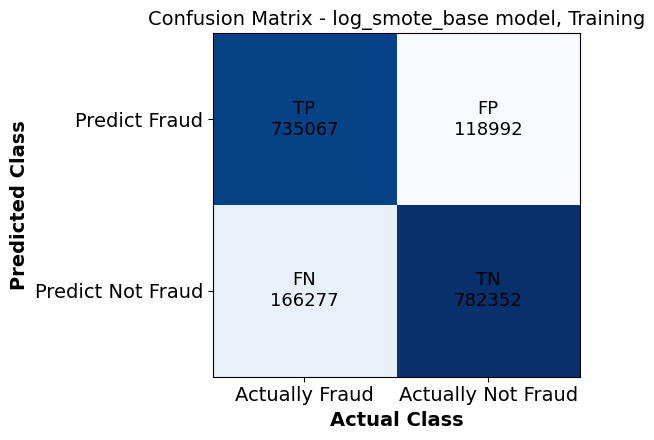

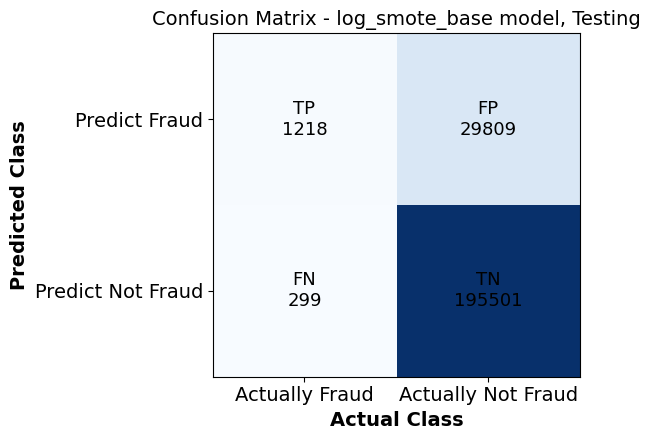

In [ ]:
# save model assessment
y_train_smote_pred = clf.predict(X_train_res)
y_test_smote_pred = clf.predict(X_sm_test)

# Print classification report
print(f'Training data: \n {classification_report(y_train_res, y_train_smote_pred)} ')
print(f'Testing data: \n {classification_report(y_test_value, y_test_smote_pred)}')

# Plot confusion matrix
display_confusion_matrix(y_train_res, y_train_smote_pred, 'log_smote_base', 'Training')
display_confusion_matrix(y_test_value, y_test_smote_pred, 'log_smote_base', 'Testing')

In [ ]:
log_base_df = get_scores('log_base', y_sm_test, y_test_smote_pred)

In [ ]:
log_base_df

,,log_base-(fraud),log_base-(non_fraud)
0,precision,0.039256,0.998473
1,recall,0.802900,0.867698
2,f1,0.074853,0.928503


Key Takeaways

30,060 instances of class 0 were misclassified as class 1. This indicates a high number of false alarms, which might be costly or problematic depending on the use case.

254 instances of class 1 were misclassified as class 0. This indicates the model is missing some true cases of the minority class, though this number is relatively small.

Use Hyperparameter tuning to find optimal ratio and use f1-score to evaluate logistical regrassion model

#### **5.1.3** Hyperparameter Tuning

In [ ]:
n_majority = max(Counter( y_sm_train).values())
n_minority = min(Counter( y_sm_train).values())
# weights = np.linspace(0.005,0.25, 10)
# weights = [w for w in weights if w * n_majority > n_minority]

In [ ]:
# set the parameters
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
# we ran this tuning before so to save to time we are using value already found
# the original value is weights = np.linspace(0.005,1, 30)
weights = [0.11388888888888889]
param_grid = {'smote__sampling_strategy' : weights}
scoring = 'f1'
pipe = Pipeline(
    [('smote',SMOTE()),('logistic',
    LogisticRegression())]
)

In [ ]:
# Grid Search
gsc = GridSearchCV(
    estimator = pipe,
    param_grid = param_grid,
    scoring = scoring,
    cv = cv,
    verbose=2
)
grid_result = gsc.fit(X_sm_train, y_sm_train)
print(f'the best paramenter is {grid_result.best_params_}')

Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV] END .......smote__sampling_strategy=0.11388888888888889; total time=  18.8s
[CV] END .......smote__sampling_strategy=0.11388888888888889; total time=  23.9s
[CV] END .......smote__sampling_strategy=0.11388888888888889; total time=  19.2s
[CV] END .......smote__sampling_strategy=0.11388888888888889; total time=  22.8s
[CV] END .......smote__sampling_strategy=0.11388888888888889; total time=  23.8s
the best paramenter is {'smote__sampling_strategy': 0.11388888888888889}


#### **5.1.4** SMOTE Train Data

In [ ]:
# get a new SMOTE fit
sm_hyer = SMOTE(sampling_strategy=0.11388888888888889, random_state=42)
X_train_res_hyper, y_train_res_hyper = sm_hyer.fit_resample(X_sm_train, y_sm_train)

### **5.2** Logistic Regression Model
Create a new logistic Regression with the new data from SMOTE

In [ ]:
clf_sm = LogisticRegression().fit(X_train_res_hyper, y_train_res_hyper)

Training data: 
               precision    recall  f1-score   support

           0       0.97      0.99      0.98    901344
           1       0.93      0.69      0.79    102653

    accuracy                           0.96   1003997
   macro avg       0.95      0.84      0.88   1003997
weighted avg       0.96      0.96      0.96   1003997
 
Testing data: 
               precision    recall  f1-score   support

           0       1.00      0.99      1.00    225310
           1       0.41      0.65      0.50      1517

    accuracy                           0.99    226827
   macro avg       0.70      0.82      0.75    226827
weighted avg       0.99      0.99      0.99    226827



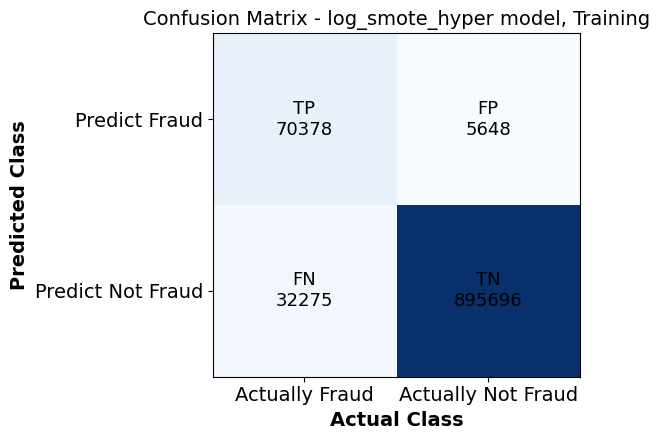

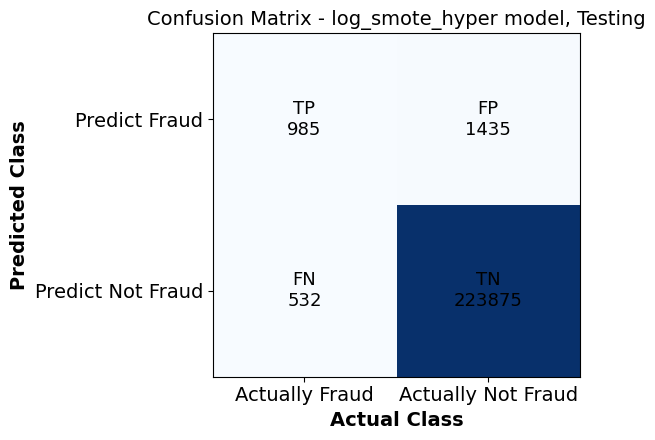

In [ ]:
# save model assessment
y_train_smote_hyper_pred = clf_sm.predict(X_train_res_hyper)
y_test_smote_hyper_pred = clf_sm.predict(X_sm_test)

# Print classification report
print(f'Training data: \n {classification_report(y_train_res_hyper, y_train_smote_hyper_pred)} ')
print(f'Testing data: \n {classification_report(y_test_value, y_test_smote_hyper_pred)}')

# Plot confusion matrix
display_confusion_matrix(y_train_res_hyper, y_train_smote_hyper_pred, 'log_smote_hyper', 'Training')
display_confusion_matrix(y_test_value, y_test_smote_hyper_pred, 'log_smote_hyper', 'Testing')

Key takeaways

- Precision improved significantly due to the lower false positive rate.
- Recall decreased slightly due to an increase in false negatives, but the model's performance overall became more balanced.
- The improvements in precision indicate the model is making more confident predictions for class 1, reducing the "false alarms" problem.

In [ ]:
# merge both log mode datafrom
log_smote_hyper_pd = get_scores('log_smote_tuning',y_sm_test, y_test_smote_hyper_pred)
log_analysis_pd = log_base_df.merge(log_smote_hyper_pd, on= '')
graph_pd = log_analysis_pd.melt(id_vars='')

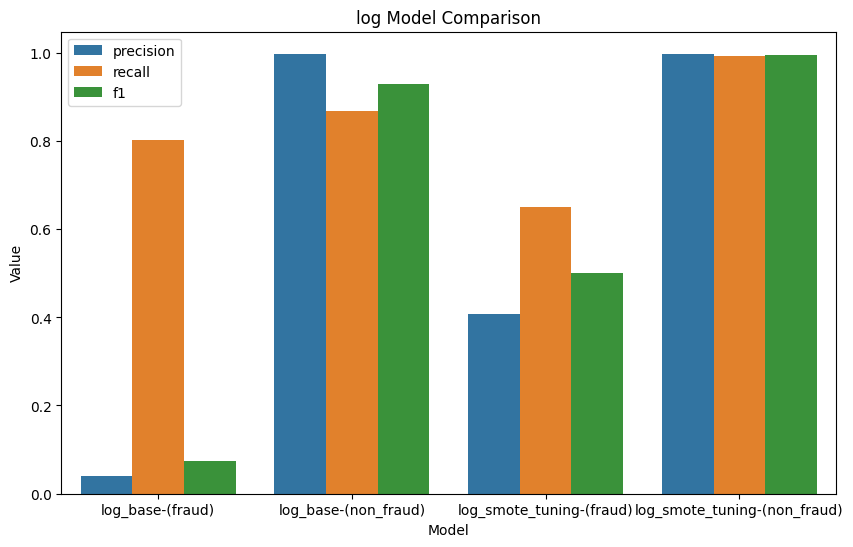

In [ ]:
plt.figure(figsize=(10, 6))
ax = sns.barplot(data = graph_pd, x = 'variable', y = 'value', hue='')
plt.title('log Model Comparison')
plt.xlabel('Model')
plt.ylabel('Value')
plt.show()

### **5.3** Random Forest

#### **5.3.1** Random Forest Base Model

In [ ]:
#base model before hyperparameter tuning
rfc = RandomForestClassifier(class_weight = 'balanced', n_estimators = 50, max_depth = 10, random_state = 42)
# Fit it to the training set
rfc.fit(X_train_res_hyper, y_train_res_hyper)

RandomForestClassifier(class_weight='balanced', max_depth=10, n_estimators=50,
                       random_state=42)

Training data: 
               precision    recall  f1-score   support

           0       1.00      0.98      0.99    901344
           1       0.85      0.97      0.91    102653

    accuracy                           0.98   1003997
   macro avg       0.92      0.98      0.95   1003997
weighted avg       0.98      0.98      0.98   1003997
 
Testing data: 
               precision    recall  f1-score   support

           0       1.00      0.98      0.99    225310
           1       0.23      0.87      0.36      1517

    accuracy                           0.98    226827
   macro avg       0.61      0.92      0.68    226827
weighted avg       0.99      0.98      0.99    226827



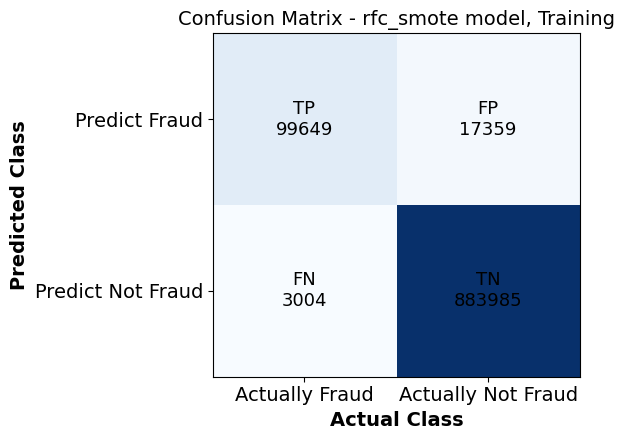

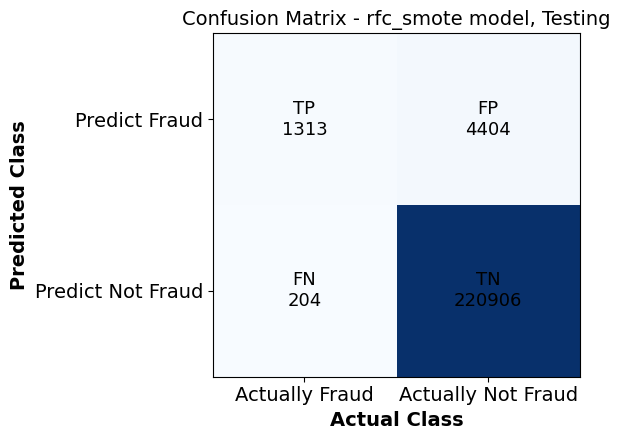

In [ ]:
# save model assessment
rfc_smote_y_train_pred = rfc.predict(X_train_res_hyper)
rfc_smote_y_test_pred  = rfc.predict(X_sm_test)

# Print classification report
print(f'Training data: \n {classification_report(y_train_res_hyper, rfc_smote_y_train_pred )} ')
print(f'Testing data: \n {classification_report(y_test_value,rfc_smote_y_test_pred)}')

# Plot confusion matrix
display_confusion_matrix(y_train_res_hyper,rfc_smote_y_train_pred , 'rfc_smote', 'Training')
display_confusion_matrix(y_test_value, rfc_smote_y_test_pred , 'rfc_smote', 'Testing')

In [ ]:
rfc_smote_base_df = get_scores('rfc_smote_base', y_sm_test, rfc_smote_y_test_pred)

#### **5.3.2**  Hyperparameter Tuning

In [ ]:
# Define the stratified cross-validation splitter with the above seed
# cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cv = 2
# Define the RandomForestClassifier with the above seed
estimator = RandomForestClassifier(random_state=42)
# Define the parameter grid we already ran through the first so
# to save time we are just going to use result
# param_grid = {
#     'class_weight': ['balanced'],
#     'n_estimators': [50, 100, 120],
#     'max_depth': [5, 10, 20]
# }
param_grid = {
    'class_weight': ['balanced'],
    'n_estimators': [120],
    'max_depth': [20]
}

# Define the metric as a lower case string (e.g. scoring = 'accuracy')
scoring = 'f1'

In [ ]:
# Set up the grid search
search = GridSearchCV(estimator=estimator, param_grid=param_grid, scoring=scoring, cv=cv, verbose=2)

# Execute the grid search by calling fit
search.fit(X_train_res_hyper, y_train_res_hyper)

Fitting 2 folds for each of 1 candidates, totalling 2 fits
[CV] END class_weight=balanced, max_depth=20, n_estimators=120; total time= 2.9min
[CV] END class_weight=balanced, max_depth=20, n_estimators=120; total time= 3.0min


GridSearchCV(cv=2, estimator=RandomForestClassifier(random_state=42),
             param_grid={'class_weight': ['balanced'], 'max_depth': [20],
                         'n_estimators': [120]},
             scoring='f1', verbose=2)

#### **5.3.2**  Random Forest After Hyperparamenter Tuning

In [ ]:
sbe_smote_y_test_pred = search.predict(X_test_value)

print(f'The best Random Forest model has hyperparameters {search.best_params_}')

The best Random Forest model has hyperparameters {'class_weight': 'balanced', 'max_depth': 20, 'n_estimators': 120}


In [ ]:
SEED = 42
rfc_hyper = RandomForestClassifier(class_weight = 'balanced', n_estimators = 120, max_depth = 20, random_state = SEED)

# Fit it to the training set
rfc_hyper.fit(X_train_res_hyper, y_train_res_hyper)

RandomForestClassifier(class_weight='balanced', max_depth=20, n_estimators=120,
                       random_state=42)

Training data: 
               precision    recall  f1-score   support

           0       1.00      1.00      1.00    901344
           1       0.98      1.00      0.99    102653

    accuracy                           1.00   1003997
   macro avg       0.99      1.00      0.99   1003997
weighted avg       1.00      1.00      1.00   1003997
 
Testing data: 
               precision    recall  f1-score   support

           0       1.00      1.00      1.00    225310
           1       0.65      0.81      0.72      1517

    accuracy                           1.00    226827
   macro avg       0.83      0.90      0.86    226827
weighted avg       1.00      1.00      1.00    226827



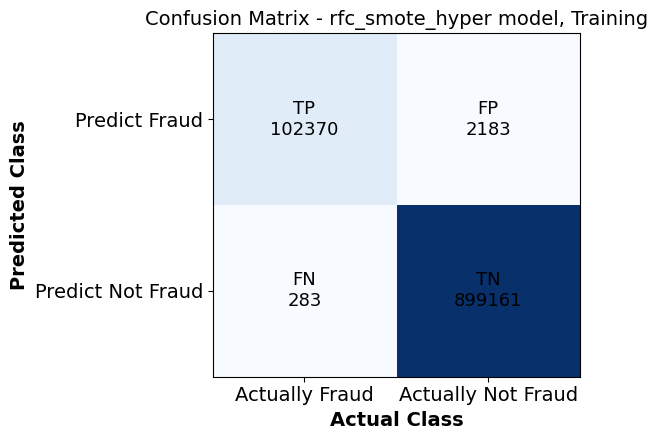

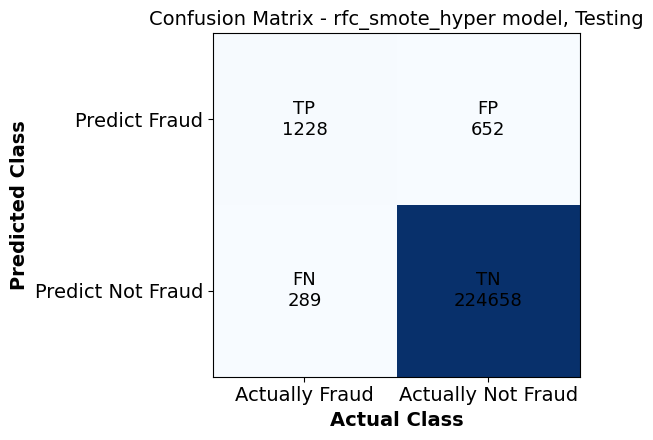

In [ ]:
rfc_smote_y_train_pred_hyper = rfc_hyper.predict(X_train_res_hyper)
rfc_smote_y_test_pred_hyper  = rfc_hyper.predict(X_sm_test)

# Print classification report
print(f'Training data: \n {classification_report(y_train_res_hyper,rfc_smote_y_train_pred_hyper )} ')
print(f'Testing data: \n {classification_report(y_test_value,rfc_smote_y_test_pred_hyper)}')

# Plot confusion matrix
display_confusion_matrix(y_train_res_hyper,rfc_smote_y_train_pred_hyper  , 'rfc_smote_hyper', 'Training')
display_confusion_matrix(y_test_value, rfc_smote_y_test_pred_hyper , 'rfc_smote_hyper', 'Testing')

In [ ]:
# merge both rfc model datafrom
rfc_smote_hyper_pd = get_scores('rfc_smote_refit',y_sm_test, rfc_smote_y_test_pred_hyper)
rfc_analysis_pd = rfc_smote_base_df.merge(rfc_smote_hyper_pd, on= '')
graph_pd = rfc_analysis_pd.melt(id_vars='')

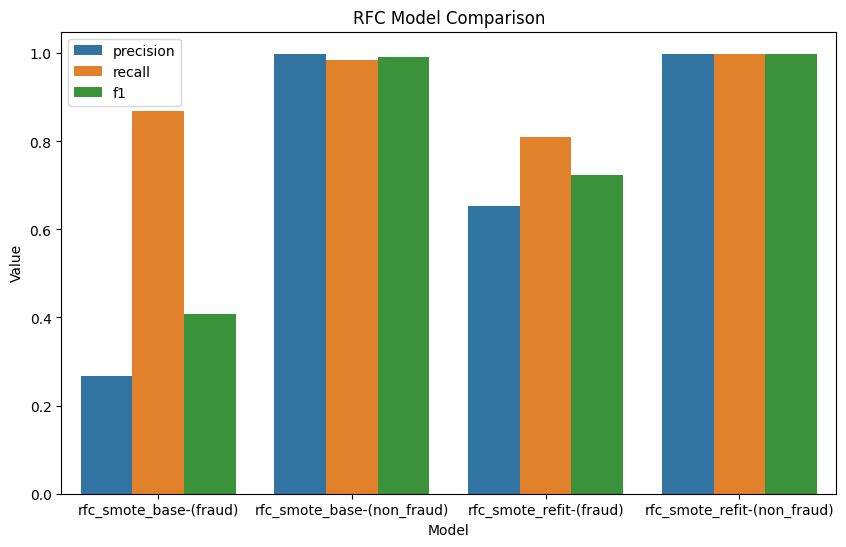

In [ ]:
plt.figure(figsize=(10, 6))
ax = sns.barplot(data = graph_pd, x = 'variable', y = 'value', hue='')
plt.title('RFC Model Comparison')
plt.xlabel('Model')
plt.ylabel('Value')
plt.show()

## **5.4** XGBoost

### **5.4.1** XGBoost Base Model

In [ ]:
unique, counts = np.unique(y_train_res_hyper, return_counts=True)
class_ratio = counts[0]/ counts[1]
class_ratio

8.780493507252588

In [ ]:
# Initialize XGBClassifier with the above class ratio
xgb = XGBClassifier(random_state = 42, tree_method = 'hist', scale_pos_weight = class_ratio, n_estimators = 50)

# Fit the classifier to our data
xgb.fit(X_train_res_hyper, y_train_res_hyper)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=50, n_jobs=None,
              num_parallel_tree=None, random_state=42, ...)

Training data: 
               precision    recall  f1-score   support

           0       1.00      0.99      1.00    901344
           1       0.95      0.99      0.97    102653

    accuracy                           0.99   1003997
   macro avg       0.98      0.99      0.98   1003997
weighted avg       0.99      0.99      0.99   1003997
 
Testing data: 
               precision    recall  f1-score   support

           0       1.00      0.99      1.00    225310
           1       0.52      0.87      0.65      1517

    accuracy                           0.99    226827
   macro avg       0.76      0.93      0.82    226827
weighted avg       1.00      0.99      0.99    226827



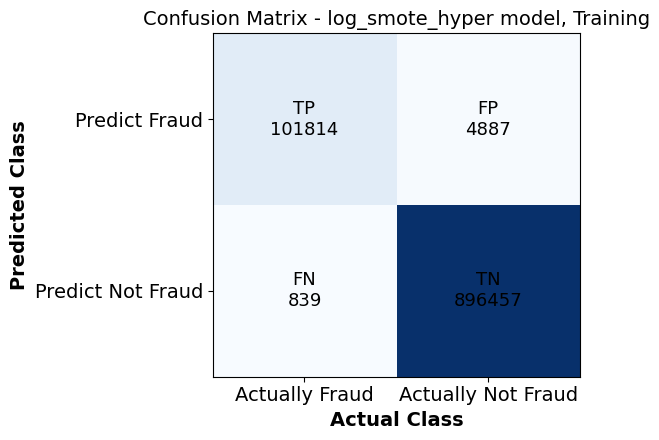

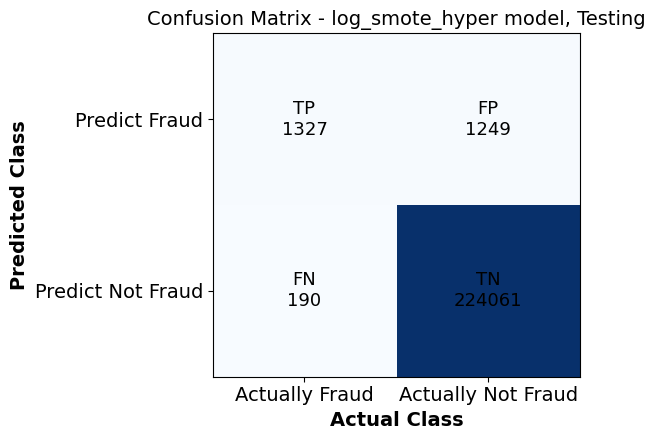

In [ ]:
xgb_smote_y_train_pred = xgb.predict(X_train_res_hyper)
xgb_smote_y_test_pred = xgb.predict(X_sm_test)

# Print classification report
print(f'Training data: \n {classification_report(y_train_res_hyper,xgb_smote_y_train_pred)} ')
print(f'Testing data: \n {classification_report(y_test_value, xgb_smote_y_test_pred)}')

# Plot confusion matrix
display_confusion_matrix(y_train_res_hyper, xgb_smote_y_train_pred , 'log_smote_hyper', 'Training')
display_confusion_matrix(y_test_value, xgb_smote_y_test_pred , 'log_smote_hyper', 'Testing')

In [ ]:
xgb_smote_base_df = get_scores('xgb_smote_base', y_sm_test, xgb_smote_y_test_pred)

### **5.4.2** Hyperparameter Tuning

In [ ]:
cv = 2
# we already ran the grid_search with the following parameters
# in order to save time we are just going to use the result from
# previous' run
# param_grid = {
#     'max_depth': [3, 5, 7],
#     'n_estimators': [50, 100, 150],
#     'scale_pos_weight': [class_ratio],
# }

param_grid = {
    'max_depth': [7],
    'n_estimators': [150],
    'scale_pos_weight': [class_ratio],
}

scoring = 'f1'

In [ ]:
xgb_clf = XGBClassifier(random_state=42, tree_method='hist')
# Define the GridSearchCV
grid_search = GridSearchCV(
    estimator=xgb_clf,
    param_grid=param_grid,
    scoring=scoring,
    cv=cv,
    verbose=2,
)

grid_search.fit(X_train_res_hyper, y_train_res_hyper)

Fitting 2 folds for each of 1 candidates, totalling 2 fits
[CV] END max_depth=7, n_estimators=150, scale_pos_weight=8.780493507252588; total time=  33.8s
[CV] END max_depth=7, n_estimators=150, scale_pos_weight=8.780493507252588; total time=  34.1s


GridSearchCV(cv=2,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     grow_policy=None, importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None,...
                                     max_cat_threshold=None,
                                     max_cat_to_onehot=None,
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=None,
                                     n_jobs=None, num_parallel_tree=None,
                                     random_state=42, ...),
             param_grid={'max_depth': [7], 'n_estimators': [150],
                         'scale_pos_weight': [8.780493507252588]},
             scoring='f1', verbose=2)

In [ ]:
# Best parameters and score
print("Best Parameters:", grid_search.best_params_)
xgb_hyper = XGBClassifier(random_state = 42,  max_depth = 7, tree_method = 'hist', scale_pos_weight = class_ratio,  n_estimators = 150)

Best Parameters: {'max_depth': 7, 'n_estimators': 150, 'scale_pos_weight': 8.780493507252588}


### **5.4.3** XGBoost After Hyperparameter Tuning

In [ ]:
xgb_hyper.fit(X_train_res_hyper, y_train_res_hyper)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=7, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=150, n_jobs=None,
              num_parallel_tree=None, random_state=42, ...)

Training data: 
               precision    recall  f1-score   support

           0       1.00      1.00      1.00    901344
           1       0.99      1.00      0.99    102653

    accuracy                           1.00   1003997
   macro avg       0.99      1.00      1.00   1003997
weighted avg       1.00      1.00      1.00   1003997
 
Testing data: 
               precision    recall  f1-score   support

           0       1.00      1.00      1.00    225310
           1       0.71      0.86      0.78      1517

    accuracy                           1.00    226827
   macro avg       0.86      0.93      0.89    226827
weighted avg       1.00      1.00      1.00    226827



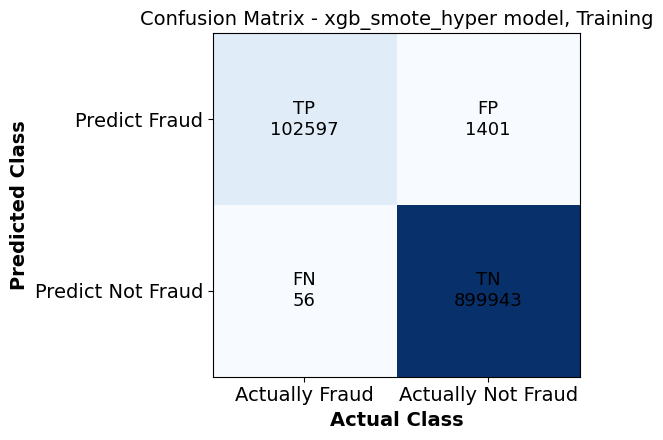

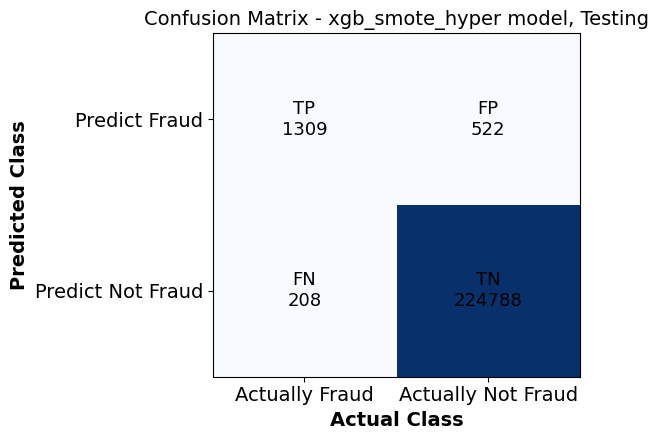

In [ ]:
xgb_smote_y_train_pred_hyper = xgb_hyper.predict(X_train_res_hyper)
xgb_smote_y_test_pred_hyper = xgb_hyper.predict(X_sm_test)

# Print classification report
print(f'Training data: \n {classification_report(y_train_res_hyper,xgb_smote_y_train_pred_hyper)} ')
print(f'Testing data: \n {classification_report(y_test_value, xgb_smote_y_test_pred_hyper)}')

# Plot confusion matrix
display_confusion_matrix(y_train_res_hyper, xgb_smote_y_train_pred_hyper , 'xgb_smote_hyper', 'Training')
display_confusion_matrix(y_test_value, xgb_smote_y_test_pred_hyper , 'xgb_smote_hyper', 'Testing')

In [ ]:
# merge both rfc model datafrom
xgb_smote_hyper_pd = get_scores('xgb_smote_refit',y_sm_test, xgb_smote_y_test_pred_hyper)
xgb_analysis_pd = xgb_smote_base_df.merge(xgb_smote_hyper_pd, on= '')
graph_pd = xgb_analysis_pd.melt(id_vars='')

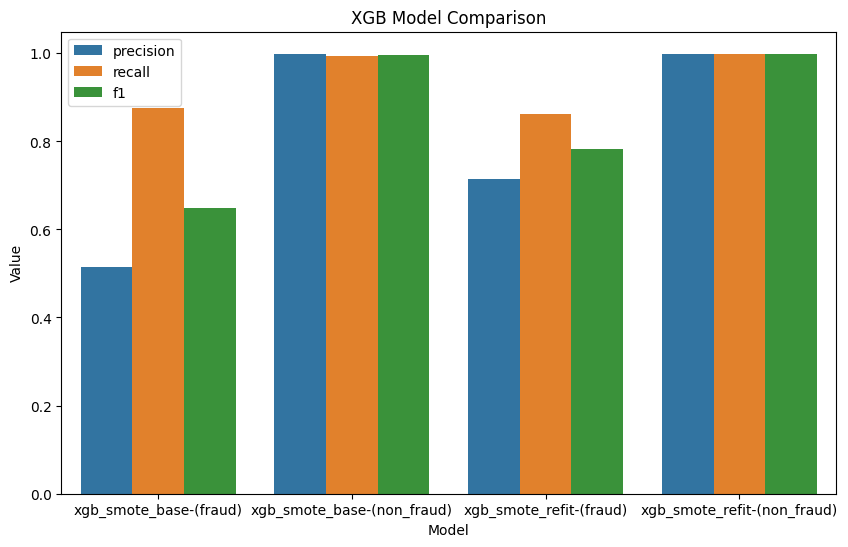

In [ ]:
plt.figure(figsize=(10, 6))
ax = sns.barplot(data = graph_pd, x = 'variable', y = 'value', hue='')
plt.title('XGB Model Comparison')
plt.xlabel('Model')
plt.ylabel('Value')
plt.show()

## **5.5** Summary

In [ ]:
all_model_pd = log_analysis_pd.merge(rfc_analysis_pd, on = '')
all_model_pd = all_model_pd.merge(xgb_analysis_pd, on = '')
graph_pd = all_model_pd.melt(id_vars='')

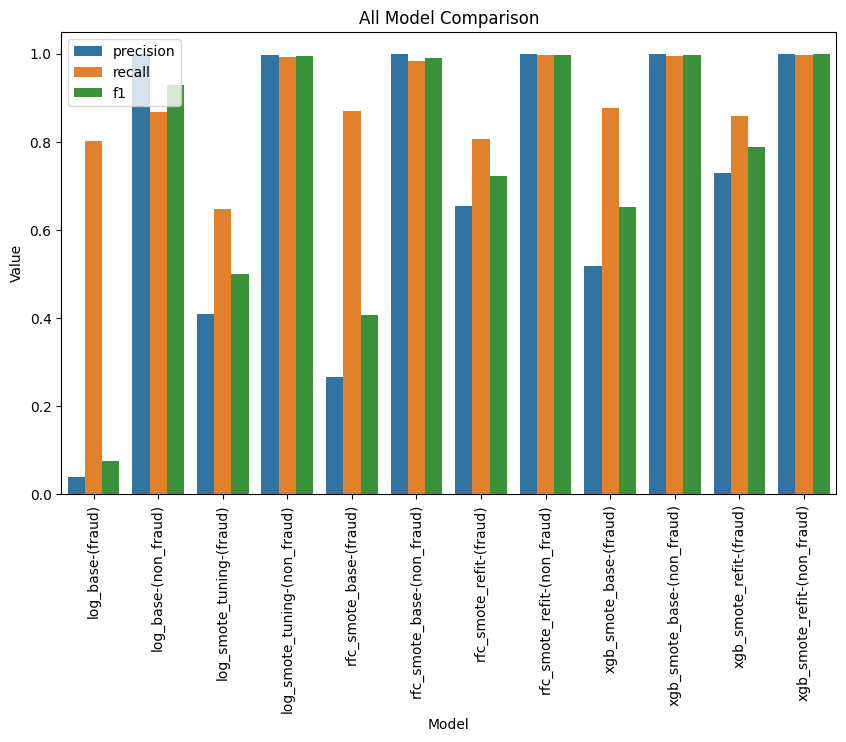

In [ ]:
plt.figure(figsize=(10, 6))
ax = sns.barplot(data = graph_pd, x = 'variable', y = 'value', hue='')
plt.title('All Model Comparison')
plt.xlabel('Model')
plt.xticks(rotation=90)
plt.ylabel('Value')
plt.show()

In [ ]:
test_only_model_pd = all_model_pd.drop(columns=['log_base-(non_fraud)',
                                                'log_smote_tuning-(non_fraud)',
                                                'rfc_smote_base-(non_fraud)',
                                                'rfc_smote_refit-(non_fraud)',
                                                'xgb_smote_base-(non_fraud)',
                                                'xgb_smote_refit-(non_fraud)',
                                                ])
test_graph = test_only_model_pd.melt(id_vars='')


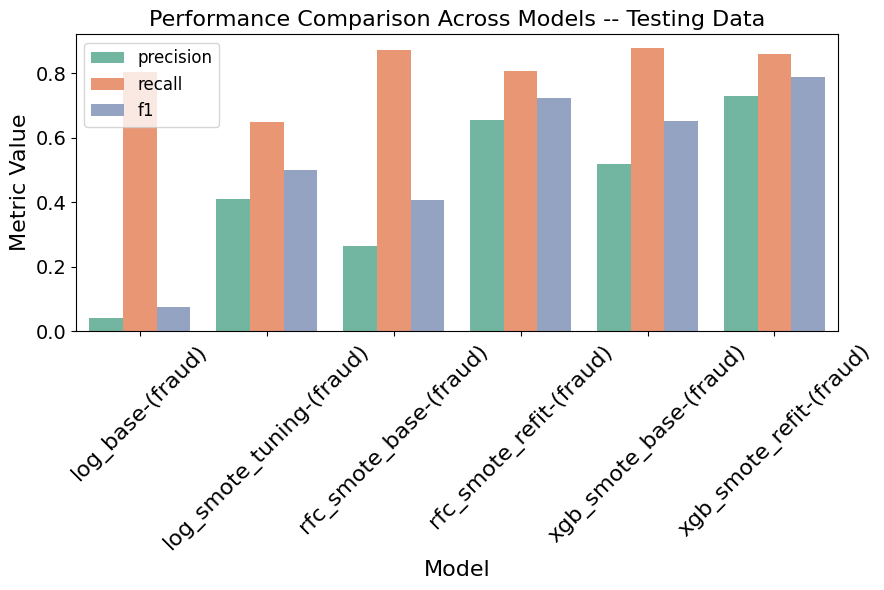

In [ ]:
# Plot the data
plt.figure(figsize=(9, 6))
sns.barplot(
    data=test_graph,
    x="variable",  # Model names (e.g., rfc_pca_before, etc.)
    y="value",  # Metric values (Precision, Recall, F1)
    hue="",  # Metrics (e.g., Precision_Fraud, Recall_Fraud, F1_Fraud, etc.)
    palette="Set2"
)

# Customize the plot
plt.title("Performance Comparison Across Models -- Testing Data", fontsize=16)
plt.xlabel("Model", fontsize=16)
plt.ylabel("Metric Value", fontsize=16)
plt.xticks(rotation=45, fontsize=16)
plt.yticks(fontsize=14)
plt.legend(fontsize=12, title_fontsize=12)
plt.tight_layout()
plt.show()


Key Takeaways:

- SMOTE significantly improves recall for fraud cases across all models, addressing the class imbalance problem.

- Hyperparameter tuning enhances model performance, with the most notable gains in recall and F1-score for fraud cases.

- XGBoost consistently outperforms logistic regression and random forest, making it the best choice when high performance is needed.

- Random forest serves as a strong alternative, offering better performance than logistic regression, especially after tuning.

# **Part 6:** Model Optimization - Feature Selection

In this section, we aim to enhance the performance of our predictive model by performing feature engineering, specifically by selecting the most important features and eliminating less relevant ones. Feature selection is a crucial step in machine learning as it helps reduce noise, improves model interpretability, and enhances computational efficiency.

**Why Reassess Features?**

The initial dataset includes a wide range of features such as:


*   Temporal features: day_of_the_week, day_period, season

*   Regional features: region_Midwest, region_Southeast, region_Southwest, region_West, region_Northeast

*   Behavioral features: amt, distance_km, city_pop, merchant_category variables

> Add blockquote


*   Demographic features: age, occupation (e.g., finance, science, blue_collar, etc.)


**Features to Retain**

Based on the feature importance analysis, the following features were identified as critical for the model:


1. **amt** (Transaction Amount): Consistently the most influential feature across both models, indicating its strong predictive power.
2.   **day_period** (Time Period): Time-related behavior often correlates with fraudulent activities, making this feature highly relevant.
3.**merchant_category_shopping, merchant_category_gas, merchant_category_grocery**: Specific merchant categories provide valuable insights into consumer behavior and potential fraud patterns.
4.**age**: While its importance is moderate, it might influence behavior patterns indirectly and is worth retaining for further analysis.
5.**city_pop** (City Population): Reflects the population size, which could indirectly influence transaction behavior.
6.**distance_km**: Although its importance is relatively low, it might capture location anomalies that are relevant for fraud detection.


**Features to Discard**

Conversely, the following features were deemed less important and are candidates for removal:

1. **day_of_the_week** (Transaction Amount): Consistently the most influential feature across both models, indicating its strong predictive power.
2.   **region_*** (Time Period): Time-related behavior often correlates with fraudulent activities, making this feature highly relevant.
3.**Occupational Features**: Specific merchant categories provide valuable insights into consumer behavior and potential fraud patterns.
4.**Other Low-Importance Merchant Categories**: While its importance is moderate, it might influence behavior patterns indirectly and is worth retaining for further analysis.


By selecting a smaller subset of highly relevant features, the model is expected to achieve better performance in terms of precision, recall, and F1-score. This feature engineering step not only improves computational efficiency but also aligns the model with domain-specific insights, ensuring a more robust and interpretable prediction system.


### **6.1.1** Dropping Features


In [ ]:
# Define the columns to drop based on feature importance analysis
columns_to_drop = [
    'day_of_the_week',       # Redundant with `day_period`
    'season',                # Likely less relevant
    'region_Midwest',
    'region_Southeast',
    'region_Southwest',
    'region_West',
    'region_Northeast',      # Regional features are less predictive
    'finance', 'science', 'blue_collar', 'media', 'business', 'engineering', 'education', 'medical', 'law', 'admin', 'art',    # Low-importance occupational features
    'mercant_category_health' #low-importance Merchant Category
]

In [ ]:
# Drop the selected columns
df_reduced = merged_df.drop(columns=columns_to_drop)


In [ ]:
# Display the remaining columns in the reduced DataFrame
print("Remaining columns after feature selection:")
print(df_reduced.columns)

Remaining columns after feature selection:
Index(['trans_num', 'is_fraud', 'day_period', 'mercant_category_gas',
       'mercant_category_grocery', 'mercant_category_home',
       'mercant_category_leisure', 'mercant_category_misc',
       'mercant_category_shopping', 'gender_M', 'other', 'age', 'distance_km',
       'city_pop', 'amt'],
      dtype='object')


### **6.1.2** Train-Test Split


In [ ]:
# Extract the features and target variable
X = df_reduced.drop(['trans_num', 'is_fraud'], axis=1)
y = df_reduced['is_fraud']

In [ ]:
# Split the data into training and testing sets
SEED = 42
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=SEED)


### **6.1.3** Standard scale numerical features


In [ ]:
numerical_features = ['age', 'distance_km', 'city_pop', 'amt']

X_train[numerical_features].describe()

,age,distance_km,city_pop,amt
count,907308.000000,907308.000000,9.073080e+05,907308.000000
mean,50.655307,76.112894,8.833470e+04,78.236562
std,17.281395,29.112981,3.017003e+05,119.130069
min,19.000000,0.093922,2.300000e+01,5.000000
25%,37.000000,55.355515,7.410000e+02,22.680000
50%,49.000000,78.220554,2.408000e+03,55.820000
75%,62.000000,98.495651,1.968500e+04,89.970000
max,100.000000,150.834590,2.906700e+06,2999.360000


In [ ]:
# Scale the numerical features by initializing the scaler and calling
numerical_features = ['age', 'distance_km', 'city_pop', 'amt']
scaler = StandardScaler()
X_train[numerical_features] = scaler.fit_transform(X_train[numerical_features])
X_test[numerical_features] = scaler.transform(X_test[numerical_features])

In [ ]:
# Convert X_train, y_train, X_test, y_test into numpy arrays
X_train_values = X_train.values
y_train_value = y_train.values
X_test_value = X_test.values
y_test_value = y_test.values

## **6.2** Base model


In [ ]:
# Fit dummy Classifier using all features
dummy = DummyClassifier(strategy="stratified")
# Train the model
dummy.fit(X_train_values, y_train_value)


DummyClassifier(strategy='stratified')

In [ ]:
# Evaluate the Model
y_train_pred = dummy.predict(X_train_values)
y_test_pred = dummy.predict(X_test_value)

# Print classification report
from sklearn.metrics import classification_report
print('training data', classification_report(y_train_value, y_train_pred))
print('testing data', classification_report(y_test_value, y_test_pred))

training data               precision    recall  f1-score   support

           0       0.99      0.99      0.99    901344
           1       0.01      0.01      0.01      5964

    accuracy                           0.99    907308
   macro avg       0.50      0.50      0.50    907308
weighted avg       0.99      0.99      0.99    907308

testing data               precision    recall  f1-score   support

           0       0.99      0.99      0.99    225310
           1       0.01      0.01      0.01      1517

    accuracy                           0.99    226827
   macro avg       0.50      0.50      0.50    226827
weighted avg       0.99      0.99      0.99    226827



In [ ]:
log_base_after_df = get_scores_1('log_base_after', y_test_value, y_test_pred)

In [ ]:
log_base_after_df

,Model,Precision_Fraud,Recall_Fraud,F1_Fraud,Precision_NonFraud,Recall_NonFraud,F1_NonFraud
0,log_base_after,0.007422,0.007251,0.007336,0.993317,0.993471,0.993394


Takeaway:
* Before Feature Selection, the dummy model predicts almost exclusively the majority class (0), with near-zero performance metrics for the minority class (1). After Feature Selection,
there is no significant change in the dummy model's performance; it continues to fail in identifying fraudulent cases.
* Feature selection alone does not improve the dummy model's ability to handle class imbalance. Its impact will be better reflected in more sophisticated models.

## **6.3** Principle component analysis (PCA)


### **6.3.1** Plot and view data in lower dimensional space

In [ ]:
def plot_pca(X, y, n_components=2):
    """
    Creates a PCA plot for the given data.

    Parameters:
    X (array-like): Feature matrix.
    y (array-like): Labels corresponding to the data points.
    n_components (int): Number of PCA components to use for the plot (default is 2).

    Returns:
    None: Displays the PCA scatter plot.
    """
    # Convert inputs to NumPy arrays if not already
    X = np.array(X)
    y = np.array(y)

    # Step 1: Apply PCA
    pca = PCA(n_components=n_components)
    X_pca = pca.fit_transform(X)

    # Step 2: Prepare for Plotting
    unique_labels = np.unique(y)
    colors = plt.cm.tab10(np.linspace(0, 1, len(unique_labels)))  # Generate distinct colors for each class

    plt.figure(figsize=(7, 6))

    # Step 3: Plot Each Class
    for label, color in zip(unique_labels, colors):
        plt.scatter(
            X_pca[y == label, 0],  # PCA component 1
            X_pca[y == label, 1],  # PCA component 2
            color=color,
            label=f"Fraud {label}",
            alpha=0.7,  # Transparency for overlapping points
            edgecolors="k"  # Black border for better visibility
        )

    plt.xlabel("Principal Component 1")
    plt.ylabel("Principal Component 2")
    plt.title("PCA - First Two Principal Components")
    plt.legend()
    plt.grid(alpha=0.3)
    plt.show()


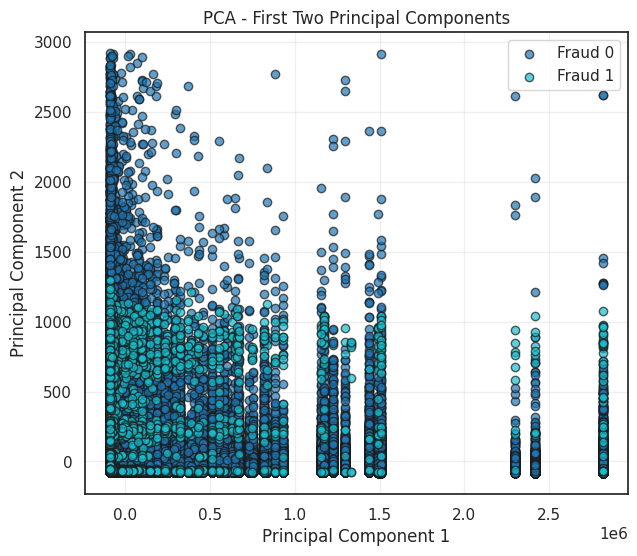

In [ ]:
plot_pca(X, y, n_components=3)

### **6.3.2** Use PCA to build logistic regression


In [ ]:
# Applying PCA function on training and testing set of X component

pca = PCA(n_components=10)

X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)

explained_variance = pca.explained_variance_ratio_


In [ ]:
explained_variance

array([0.21319319, 0.1701661 , 0.15703721, 0.15586031, 0.14257736,
       0.0388765 , 0.02925664, 0.02601786, 0.02354185, 0.02147021])

In [ ]:
# Fitting Logistic Regression To the training set

pca_mlr = LogisticRegression(random_state=42)
pca_mlr.fit(X_train_pca, y_train)

LogisticRegression(random_state=42)

### **6.3.3** Predict and evaluate model performance


In [ ]:
# Predicting the test set result
y_train_pred = pca_mlr.predict(X_train_pca)
y_test_pred = pca_mlr.predict(X_test_pca)

# Print classification report
print("Training data: ", classification_report(y_train_value, y_train_pred))
print("Testing data: ", classification_report(y_test_value, y_test_pred))

Training data:                precision    recall  f1-score   support

           0       0.99      1.00      1.00    901344
           1       0.26      0.06      0.09      5964

    accuracy                           0.99    907308
   macro avg       0.63      0.53      0.55    907308
weighted avg       0.99      0.99      0.99    907308

Testing data:                precision    recall  f1-score   support

           0       0.99      1.00      1.00    225310
           1       0.27      0.06      0.09      1517

    accuracy                           0.99    226827
   macro avg       0.63      0.53      0.54    226827
weighted avg       0.99      0.99      0.99    226827



In [ ]:
rfc_pca_after_df = get_scores_1('log_pca_after', y_test_value, y_test_pred)

Takeaway:
* Before PCA Feature Selection:
After applying PCA, the model still heavily favors the majority class (0). Metrics for the minority class (1) remain extremely low, with an F1-score of 0.11 on the training data and 0.10 on the testing data. This indicates the PCA transformation alone does not effectively address the class imbalance or improve the model's ability to identify fraudulent cases.
* After PCA Feature Selection:
Even with feature selection combined with PCA, the model's performance on the minority class shows no significant improvement. Metrics for class 1 (fraud) remain low, with a slight increase in precision but no meaningful change in recall or F1-score.

* PCA transformation, either with or without prior feature selection, does not resolve the class imbalance issue. Improvements in model performance will likely require a combination of advanced modeling techniques (e.g., ensemble methods like Random Forest or XGBoost) and imbalance mitigation strategies such as oversampling (SMOTE) or class weighting.

## **6.4** Multivariate logistics regression with L2 regularization

### **6.4.1** Fitting model

In [ ]:
# Create a class-weighted logistic, the model using Regularization, setting strength of penalty as 1
weighted_mlg = LogisticRegression(class_weight='balanced', penalty='l2')
# weighted_mlg = LogisticRegression(class_weight='balanced', penalty='l2', C=1, solver='saga')
# weighted_mlg = LogisticRegression(class_weight='balanced', penalty='l2', C=1, solver='saga', max_iter=1000)
# Train the model
weighted_mlg.fit(X_train, y_train)


LogisticRegression(class_weight='balanced')

### **6.4.2** Prediction and model evaluation


In [ ]:
# Make predictions
weighted_mlg_y_train_pred = weighted_mlg.predict(X_train)
weighted_mlg_y_test_pred = weighted_mlg.predict(X_test)

# Print classification report
from sklearn.metrics import classification_report
print(classification_report(y_train, weighted_mlg_y_train_pred))
print(classification_report(y_test, weighted_mlg_y_test_pred))

              precision    recall  f1-score   support

           0       1.00      0.87      0.93    901344
           1       0.04      0.81      0.07      5964

    accuracy                           0.87    907308
   macro avg       0.52      0.84      0.50    907308
weighted avg       0.99      0.87      0.92    907308

              precision    recall  f1-score   support

           0       1.00      0.87      0.93    225310
           1       0.04      0.81      0.07      1517

    accuracy                           0.87    226827
   macro avg       0.52      0.84      0.50    226827
weighted avg       0.99      0.87      0.92    226827



In [ ]:
rfc_after_lr_pd = get_scores_1('log_lr_after',y_test, weighted_mlg_y_test_pred)


Takeaway:
* Before Feature Selection, high recall (0.81) but very low precision (0.04) and F1-score (0.07) for the minority class (1).
Majority class (0) metrics remain strong, with high precision and recall (~0.87–0.93).
* After Feature Selection: Minimal change in performance; metrics for both classes remain largely consistent.
* Feature selection alone does not improve the model’s ability to handle class imbalance. Further strategies like oversampling or class weighting are needed to boost minority class performance.

## **6.5** Random Forest


### **6.5.1** Fitting model

In [ ]:
# Initialize the RandomForestClassifier with the above parameters
SEED = 42
rfc = RandomForestClassifier(class_weight = 'balanced', n_estimators = 120, max_depth = 10, random_state = SEED)

# Fit it to the training set
rfc.fit(X_train, y_train)

RandomForestClassifier(class_weight='balanced', max_depth=10, n_estimators=50,
                       random_state=42)

### **6.5.2** Prediction and model evaluation


In [ ]:
# Predict on the training and testing set
rfc_y_train_pred = rfc.predict(X_train)
rfc_y_test_pred = rfc.predict(X_test)

In [ ]:
# Print classification report
from sklearn.metrics import classification_report
print(classification_report(y_train, rfc_y_train_pred))
print(classification_report(y_test, rfc_y_test_pred))

              precision    recall  f1-score   support

           0       1.00      0.98      0.99    901344
           1       0.23      0.95      0.37      5964

    accuracy                           0.98    907308
   macro avg       0.61      0.97      0.68    907308
weighted avg       0.99      0.98      0.99    907308

              precision    recall  f1-score   support

           0       1.00      0.98      0.99    225310
           1       0.22      0.92      0.36      1517

    accuracy                           0.98    226827
   macro avg       0.61      0.95      0.67    226827
weighted avg       0.99      0.98      0.98    226827



In [ ]:
rfc_after_pd = get_scores_1('log_rfc_after',y_test, rfc_y_test_pred)




Takeaway:
* Performance for Majority Class (0):
The Random Forest model consistently performs well for the majority class, maintaining high precision, recall, and F1-score (0.99) both before and after feature selection.
* Performance for Minority Class (1): After feature selection, recall for the minority class improves slightly (from 0.88 to 0.92 to 0.95), indicating better sensitivity in identifying fraudulent cases. However, precision remains low (0.22 to 0.23), resulting in a marginal improvement in the F1-score.
* Conclusion:
Feature selection has a minor positive effect, particularly in improving recall for the minority class, but it does not address the low precision issue. Further steps, such as class balancing techniques, are needed to enhance the model's ability to handle the imbalanced dataset.

## **6.6** XGBoost


### **6.6.1** Fitting model

In [ ]:
# Find the ratio of imbalanced classes
class_ratio = merged_df['is_fraud'].value_counts()[0] / merged_df['is_fraud'].value_counts()[1]
class_ratio

150.60205854832242

In [ ]:

# Initialize XGBClassifier with the above class ratio
xgb_clf = XGBClassifier(random_state = SEED, tree_method = 'hist', scale_pos_weight = 1, n_estimators = 120)

# Fit the classifier to our data
xgb_clf.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=50, n_jobs=None,
              num_parallel_tree=None, random_state=42, ...)

### **6.6.2** Prediction and model evaluation


In [ ]:
# Prediction using the XGB classifier
xgb_clf_y_train_pred = xgb_clf.predict(X_train)
xgb_clf_y_test_pred = xgb_clf.predict(X_test)


In [ ]:
# Print classification report
from sklearn.metrics import classification_report
print(classification_report(y_train, xgb_clf_y_train_pred))
print(classification_report(y_test, xgb_clf_y_test_pred))


              precision    recall  f1-score   support

           0       1.00      0.98      0.99    901344
           1       0.23      0.99      0.37      5964

    accuracy                           0.98    907308
   macro avg       0.61      0.99      0.68    907308
weighted avg       0.99      0.98      0.98    907308

              precision    recall  f1-score   support

           0       1.00      0.98      0.99    225310
           1       0.22      0.94      0.36      1517

    accuracy                           0.98    226827
   macro avg       0.61      0.96      0.67    226827
weighted avg       0.99      0.98      0.98    226827





Takeaway:
* Performance for Majority Class (0):
The model maintains consistently excellent performance for the majority class across both training and testing data, with an F1-score of 0.99 both before and after feature selection.
* Performance for Minority Class (1): After feature selection, the recall for the minority class remains high (0.95–0.99), but precision stays low (~0.22–0.24), resulting in a slightly improved or stable F1-score (0.36–0.39).
* Conclusion:
Feature selection has minimal impact on the XGBoost model’s performance. While it helps maintain high recall for the minority class, the low precision persists, suggesting the need for further class balancing or optimization techniques to improve minority class predictions.

In [ ]:
log_after_xgboost = get_scores_1('log_xgb_after',y_test, xgb_clf_y_test_pred)


## **6.7** Model Performance Visualization


### **6.7.1** Combine All Model Scores

In this step, we combine the performance scores (Precision, Recall, F1) of all models before and after feature selection or PCA into a single dataframe.This allows us to prepare the data for comparative visualization.

In [ ]:
# Combine all scores into a single dataframe
all_scores_df = pd.concat([
    dummy_before,
    log_base_after_df,
    pca_mlr_before,
    rfc_pca_after_df,
    wmlr_before,
    rfc_after_lr_pd,
    rfc_refit_before,
    rfc_after_pd,
    xgboost_refit_before,
    log_after_xgboost
], ignore_index=True)


### **6.7.2** Prepare Data for Visualization

To visualize the performance metrics (Precision, Recall, F1) for all models,we reshape the dataframe into a "long" format using the melt function. This makes it easier to plot multiple metrics across all models in one figure.

In [ ]:
# Melt the dataframe for visualization
all_scores_melted = pd.melt(
    all_scores_df,
    id_vars=["Model"],  # Keep the 'Model' column
    var_name="Metric",  # Combine all metric columns (e.g., Precision_Fraud, Recall_Fraud, etc.)
    value_name="Value"  # The values for each metric
)


### **6.7.3** Plot Model Performance

We create a bar plot to compare the performance metrics (Precision, Recall, F1)across all models. Different metrics are displayed using different colors.


<ipython-input-163-7f2128590f59>:3: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(


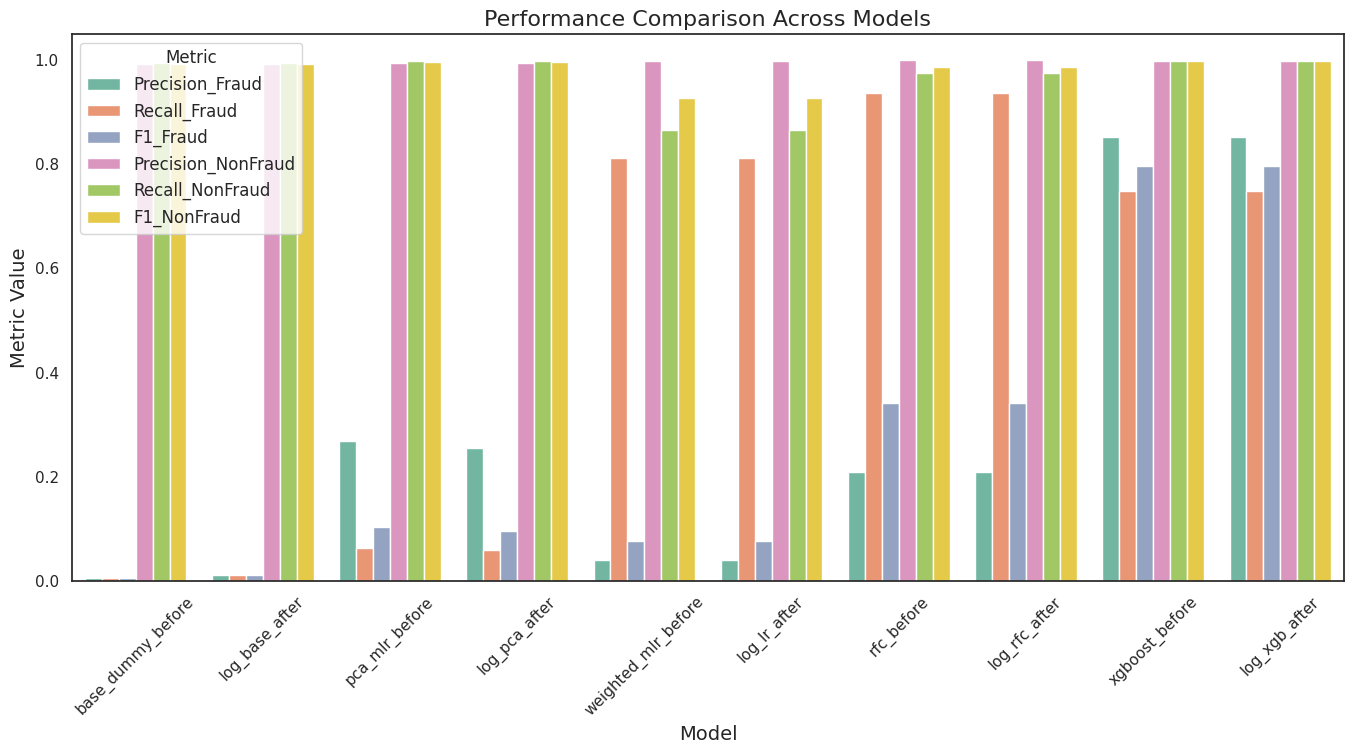

In [ ]:
# Plot the data
plt.figure(figsize=(14, 8))
sns.barplot(
    data=all_scores_melted,
    x="Model",  # Model names (e.g., rfc_pca_before, etc.)
    y="Value",  # Metric values (Precision, Recall, F1)
    hue="Metric",  # Metrics (e.g., Precision_Fraud, Recall_Fraud, F1_Fraud, etc.)
    ci=None,
    palette="Set2"
)

# Customize the plot
plt.title("Performance Comparison Across Models", fontsize=16)
plt.xlabel("Model", fontsize=14)
plt.ylabel("Metric Value", fontsize=14)
plt.xticks(rotation=45)
plt.legend(title="Metric", fontsize=12)
plt.tight_layout()

plt.show()


**conclusion:**

Feature selection shows minimal impact on model performance. Metrics such as precision, recall, and F1 score for both fraud and non-fraud classes remain largely unchanged, indicating that the selected features already carried the most relevant information for classification. The process neither significantly enhanced nor degraded the models' effectiveness.

## **Part 7:** Summary and Conclusion

In [ ]:
summary_pd = test_graph.merge(model_scores_melted_fraud, on = )